# MOOD CLASSIFICATION IN MUSIC

### Author: Rhaam Rozenberg

##### Before this program can work you MUST fill in the client id and client secret 

In [1]:
import numpy as np
import pandas as pd
import spotipy 
import spotipy.util as util
import os

from spotipy.oauth2 import SpotifyOAuth #added

#ml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

#graphs
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from math import pi
import operator

#normalization
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math


# MUST BE FILLED IN
CLIENT_ID = ''
CLIENT_SECRET =''

token = spotipy.oauth2.SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

cache_token = token.get_access_token()

sp = spotipy.Spotify(cache_token)

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.


## starting with a few playlists

In [2]:
playlist_mood_list=["Anger","Love","Happy","Sad"]

angry_playlist_list=["6oxSqwtAseyUm65MWl8JEM","37i9dQZF1DX1fmyMdW2PaL","37i9dQZF1DX3ND264N08pv"]
love_playlist_list=["37i9dQZF1DWYMvTygsLWlG","37i9dQZF1DX0QKpU3cGsyb","37i9dQZF1DX7rOY2tZUw1k"]
happy_playlist_list=["37i9dQZF1DXdPec7aLTmlC","37i9dQZF1DWSf2RDTDayIx","1h90L3LP8kAJ7KGjCV2Xfd"] #first 2 by spotify 3rd filtr us
sad_playlist_list=["44tRfteJJzAmUONSiA56bQ","37i9dQZF1DWSqBruwoIXkA","37i9dQZF1DX3YSRoSdA634"]

In [3]:
#get all songs features for a playlist
def get_playlist_tracks(playlist_list):
    
    playlist_songs=pd.DataFrame(columns=["id","danceability","energy","key","loudness","mode", "speechiness","instrumentalness",
                                             "liveness","valence","tempo", "duration_ms","time_signature"])
    
    for playlist_id in playlist_list:
                        
        total_songs = sp.playlist_items(playlist_id, fields=None, limit=100)['total']

        print('total songs in playlist '+ str(playlist_id)+" "+ str(total_songs))

        if(total_songs<100):
            playlist = sp.playlist_items(playlist_id, fields=None, limit=100,additional_types=('track', 'episode'))

            for i in range(total_songs):#only up to 100 the function has a limit
                playlist_songs=playlist_songs.append(sp.audio_features(playlist['items'][i]['track']['id']), ignore_index=True)

        else:
            shift=0
            number_songs_gotten=0

            for i in range(math.ceil(total_songs/100)):

                playlist = sp.playlist_items(playlist_id, fields=None, limit=100,offset=shift,additional_types=('track', 'episode'))

                if(total_songs-number_songs_gotten<100):
                    for j in range(total_songs-number_songs_gotten):
                        playlist_songs=playlist_songs.append(sp.audio_features(playlist['items'][j]['track']['id']), ignore_index=True)
                else:
                    for j in range(100):
                            playlist_songs=playlist_songs.append(sp.audio_features(playlist['items'][j]['track']['id']), ignore_index=True)
                            number_songs_gotten=number_songs_gotten+1

                shift=shift+100
            
            
   # playlist_songs=playlist_songs.drop(['id','uri','track_href','analysis_url','type'],axis=1)
    playlist_songs=playlist_songs.drop(['uri','track_href','analysis_url','type'],axis=1)

    
    return playlist_songs

## getting all the songs and their features in each of our playlists

In [4]:
playlist_1_with_ids=get_playlist_tracks(angry_playlist_list)
playlist_1=playlist_1_with_ids.drop(['id'],axis=1)

total songs in playlist 6oxSqwtAseyUm65MWl8JEM 195
total songs in playlist 37i9dQZF1DX1fmyMdW2PaL 100
total songs in playlist 37i9dQZF1DX3ND264N08pv 100


In [5]:
playlist_2_with_ids=get_playlist_tracks(love_playlist_list)
playlist_2=playlist_2_with_ids.drop(['id'],axis=1)

total songs in playlist 37i9dQZF1DWYMvTygsLWlG 100
total songs in playlist 37i9dQZF1DX0QKpU3cGsyb 75
total songs in playlist 37i9dQZF1DX7rOY2tZUw1k 100


In [6]:
playlist_3_with_ids=get_playlist_tracks(happy_playlist_list)
playlist_3=playlist_3_with_ids.drop(['id'],axis=1)

total songs in playlist 37i9dQZF1DXdPec7aLTmlC 100
total songs in playlist 37i9dQZF1DWSf2RDTDayIx 125
total songs in playlist 1h90L3LP8kAJ7KGjCV2Xfd 98


In [7]:
playlist_4_with_ids=get_playlist_tracks(sad_playlist_list)
playlist_4=playlist_4_with_ids.drop(['id'],axis=1)

total songs in playlist 44tRfteJJzAmUONSiA56bQ 118
total songs in playlist 37i9dQZF1DWSqBruwoIXkA 129
total songs in playlist 37i9dQZF1DX3YSRoSdA634 150


# Creating the graphs

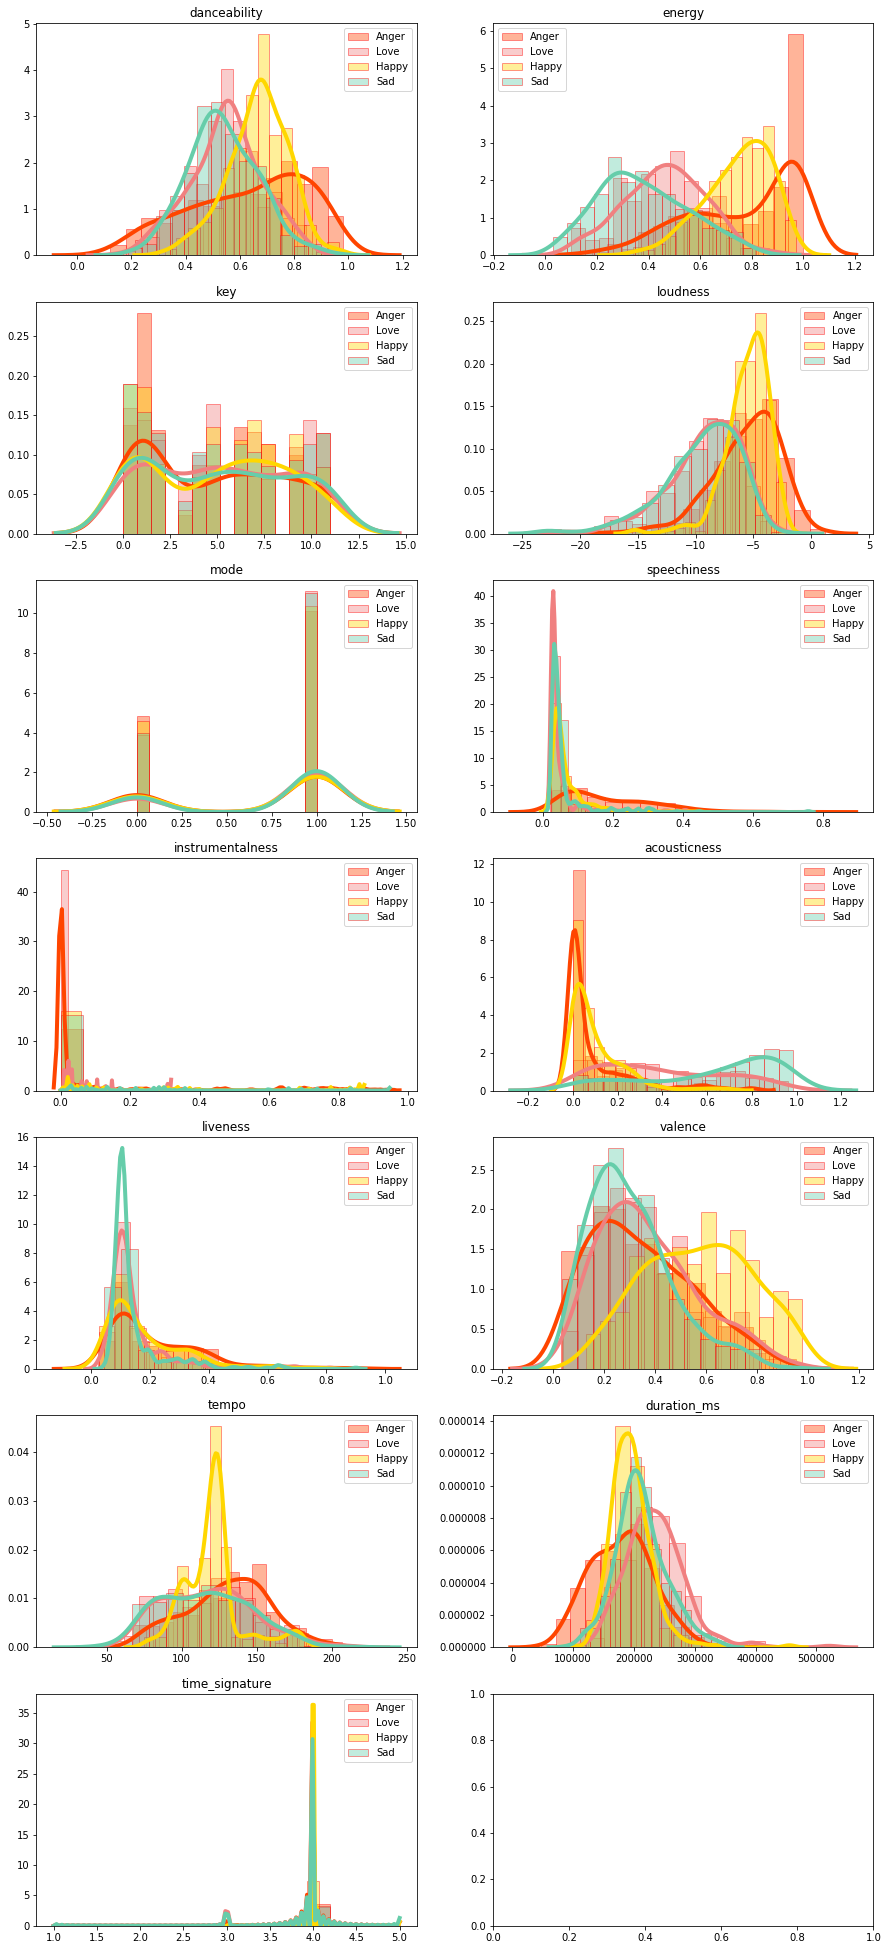

In [8]:
features=["danceability","energy","key",
          "loudness","mode", "speechiness",
          "instrumentalness","acousticness",
        "liveness","valence","tempo", "duration_ms","time_signature"]

number_of_bins=15

fig, axs = plt.subplots(figsize=(15, 35), nrows=7, ncols=2)

axs=axs.flatten()

figure_number=0

for feature in features[:]:
        
    ax=axs[figure_number]
    ax.set_title(feature)
    
    playlist_1_features_list=[]
    playlist_2_features_list =[]
    playlist_3_features_list=[]
    playlist_4_features_list =[]

    for i in range(len(playlist_1.index)):
        playlist_1_features_list.append(playlist_1.loc[i][feature])

    for i in range(len(playlist_2.index)):
        playlist_2_features_list.append(playlist_2.loc[i][feature])

    for i in range(len(playlist_3.index)):
        playlist_3_features_list.append(playlist_3.loc[i][feature])

    for i in range(len(playlist_4.index)):
        playlist_4_features_list.append(playlist_4.loc[i][feature])
     

    sns.distplot(playlist_1_features_list, hist=True, bins=number_of_bins, color = 'orangered', hist_kws={'edgecolor':'red'}, kde_kws={'linewidth': 4}, ax=ax, label='Anger')
    sns.distplot(playlist_2_features_list, hist=True, bins=number_of_bins, color = 'lightcoral', hist_kws={'edgecolor':'red'}, kde_kws={'linewidth': 4}, ax=ax, label='Love')
    sns.distplot(playlist_3_features_list, hist=True, bins=number_of_bins, color = 'gold', hist_kws={'edgecolor':'red'}, kde_kws={'linewidth': 4}, ax=ax, label='Happy')
    sns.distplot(playlist_4_features_list, hist=True, bins=number_of_bins, color = 'mediumaquamarine', hist_kws={'edgecolor':'red'}, kde_kws={'linewidth': 4}, ax=ax, label='Sad')
    ax.legend()
    
    figure_number=figure_number+1
    

## Normalize

In [9]:
min_max_scaler = MinMaxScaler()

data_normalized_df_1=playlist_1
data_normalized_df_2=playlist_2
data_normalized_df_3=playlist_3
data_normalized_df_4=playlist_4

#dropping liveness its not useful
data_normalized_df_1=data_normalized_df_1.drop(['liveness'], axis=1)
data_normalized_df_2=data_normalized_df_2.drop(['liveness'], axis=1)
data_normalized_df_3=data_normalized_df_3.drop(['liveness'], axis=1)
data_normalized_df_4=data_normalized_df_4.drop(['liveness'], axis=1)

#normalize
data_normalized_df_1.loc[:]=min_max_scaler.fit_transform(data_normalized_df_1.loc[:])
data_normalized_df_2.loc[:]=min_max_scaler.fit_transform(data_normalized_df_2.loc[:])
data_normalized_df_3.loc[:]=min_max_scaler.fit_transform(data_normalized_df_3.loc[:])
data_normalized_df_4.loc[:]=min_max_scaler.fit_transform(data_normalized_df_4.loc[:])

# adding column named playlist with the name of the playlist for each song
data_normalized_df_1['playlist']=playlist_mood_list[0]
data_normalized_df_2['playlist']=playlist_mood_list[1]
data_normalized_df_3['playlist']=playlist_mood_list[2]
data_normalized_df_4['playlist']=playlist_mood_list[3]


playlist_normalized_dfs=(data_normalized_df_1,data_normalized_df_2,
                         data_normalized_df_3,data_normalized_df_4)

# combining data frames
ml_df = pd.concat(playlist_normalized_dfs, ignore_index = True)


In [10]:
 # create a list with the average of all features
value_1=list(data_normalized_df_1.mean())
value_2=list(data_normalized_df_2.mean())
value_3=list(data_normalized_df_3.mean())
value_4=list(data_normalized_df_4.mean())

# repeat first value to close the circle
value_1+=value_1[:1]
value_2+=value_2[:1]
value_3+=value_3[:1]
value_4+=value_4[:1]

#interesting_features=["danceability","energy","loudness", "speechiness","acousticness","valence","instrumentalness","tempo"]
interesting_features=["danceability","energy","key","loudness","mode", "speechiness","instrumentalness",
                      "valence","tempo","duration_ms","time_signature","acousticness"]
# number of categories
N=len(interesting_features)

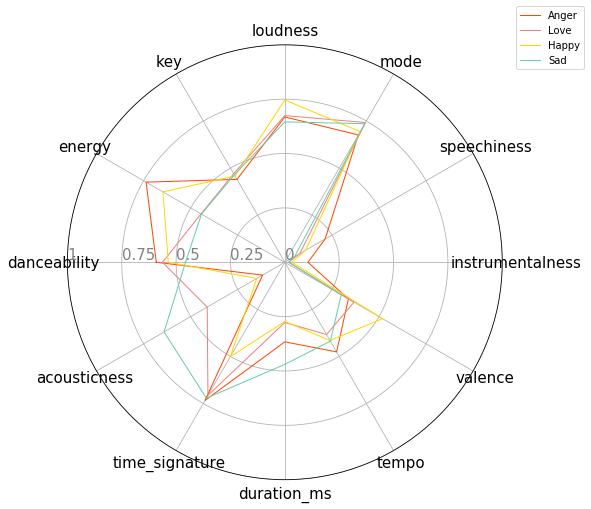

In [11]:
# plot size
fig=plt.figure(figsize=(8,8))
    
# calculate angle for each category
angles=[n/float(N)*2*math.pi for n in range(N)]
angles+=angles[:1]

ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi)
ax.set_theta_direction(-1)

# plot

plt.xticks(angles, interesting_features)

ax.set_rlabel_position(0)
plt.yticks([0,0.25 ,0.5,0.75 ,1], ["0","0.25", "0.5","0.75", "1"], color="grey", size=7)
plt.ylim(0, 1)

#plotting the lines
ax.plot(angles, value_1, color='orangered', linewidth=1, linestyle='solid', label='Anger')
ax.plot(angles, value_2, color='lightcoral', linewidth=1, linestyle='solid', label='Love')
ax.plot(angles, value_3, color='gold', linewidth=1, linestyle='solid', label='Happy')
ax.plot(angles, value_4, color='mediumaquamarine', linewidth=1, linestyle='solid', label='Sad')


plt.xticks(angles[:-1],interesting_features, size=15)
plt.yticks(color='gray',size=15)

#add legend
ax.legend(bbox_to_anchor=(1.2, 1.1))

plt.show()
    





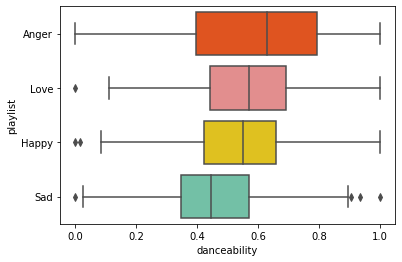

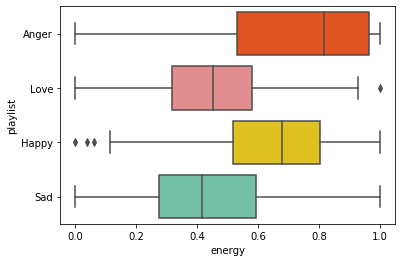

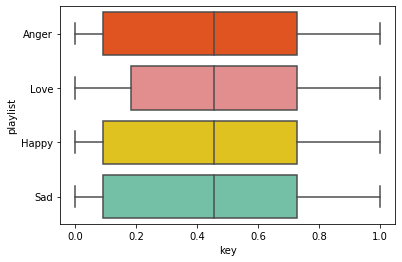

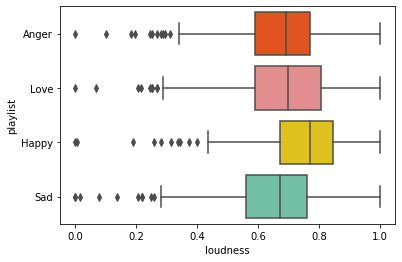

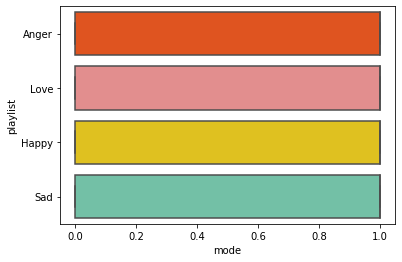

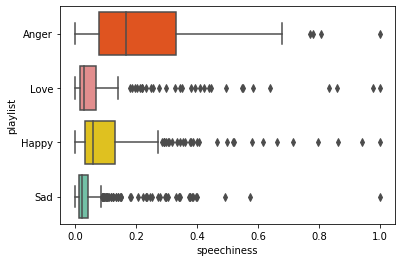

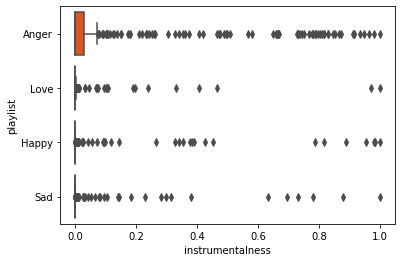

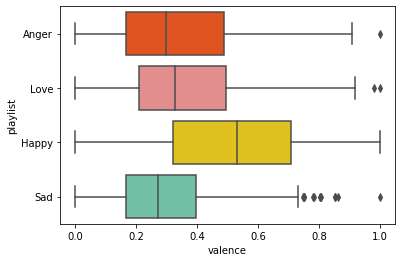

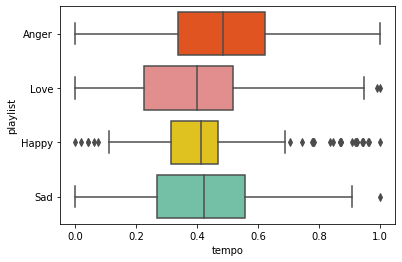

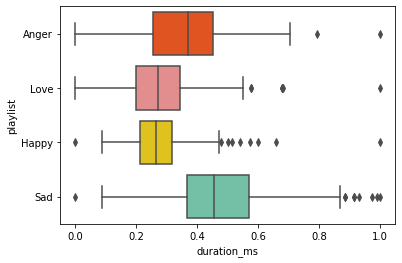

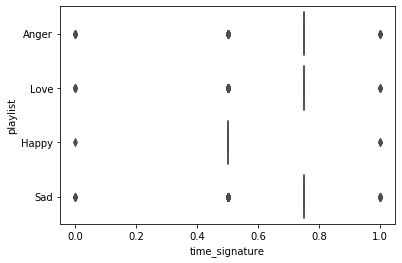

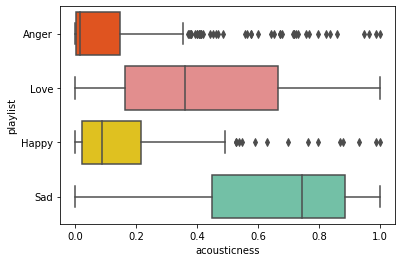

In [12]:
#box plots
my_pallet = {"Anger": "orangered", "Love": "lightcoral", "Happy":"gold", "Sad":"mediumaquamarine"}


for feature in interesting_features:
    sns.boxplot( y=ml_df["playlist"], x=ml_df[feature], palette=my_pallet );
    plt.show()

# Finding Outliers

An important note, in the function where I drop rows that do not contain oultliers I only consider outliers to be be songs with 2 or more features outside the iqr. The reason for this is that outherwise more than half of the songs would be considered outliers if it only took 1 feature outside the iqr to be considered an outlier, additionally instrumentalnes is almost always an outlier except for calm music.


In [13]:
def add_number_outliers_column(df_to_edit):
    
    df_to_edit['outlier_count']=0
    #df_to_edit=df_to_edit.drop(['instrumentalness'],axis=1)
    
    for i in range(len(df_to_edit.index)):

        outlier_feature_count=0

        if df_to_edit.loc[i]['danceability']== True: 
            outlier_feature_count=outlier_feature_count+1
        if df_to_edit.loc[i]['energy']==True:
            outlier_feature_count=outlier_feature_count+1
        if df_to_edit.loc[i]['loudness']== True:
            outlier_feature_count=outlier_feature_count+1
        if df_to_edit.loc[i]['speechiness']==True: 
            outlier_feature_count=outlier_feature_count+1
        if df_to_edit.loc[i]['acousticness']==True:
            outlier_feature_count=outlier_feature_count+1
        if df_to_edit.loc[i]['valence']==True:
            outlier_feature_count=outlier_feature_count+1
        if df_to_edit.loc[i]['instrumentalness']==True:
            outlier_feature_count=outlier_feature_count+1
        if df_to_edit.loc[i]['tempo']==True:
            outlier_feature_count=outlier_feature_count+1

        df_to_edit['outlier_count'][i]=outlier_feature_count
        
    return df_to_edit

In [14]:
#data sets to use 
#need to normalize these

playlist_1_with_ids_normalized=data_normalized_df_1
playlist_2_with_ids_normalized=data_normalized_df_2
playlist_3_with_ids_normalized=data_normalized_df_3
playlist_4_with_ids_normalized=data_normalized_df_4

#adding ids to the normalized data
playlist_1_with_ids_normalized['id']=playlist_1_with_ids['id']
playlist_2_with_ids_normalized['id']=playlist_2_with_ids['id']
playlist_3_with_ids_normalized['id']=playlist_3_with_ids['id']
playlist_4_with_ids_normalized['id']=playlist_4_with_ids['id']


In [15]:
#creating dictionaries with the iqr from each feature for each playlist
iqr_dict_1={}
iqr_dict_2={}
iqr_dict_3={}
iqr_dict_4={}

playlist_1_outliers=pd.DataFrame()
playlist_1_outliers['id']=playlist_1_with_ids['id']
playlist_2_outliers=pd.DataFrame()
playlist_2_outliers['id']=playlist_2_with_ids['id']
playlist_3_outliers=pd.DataFrame()
playlist_3_outliers['id']=playlist_3_with_ids['id']
playlist_4_outliers=pd.DataFrame()
playlist_4_outliers['id']=playlist_4_with_ids['id']


for feature in interesting_features:
    Q1 = playlist_1_with_ids_normalized[feature].quantile(0.25)
    Q3 = playlist_1_with_ids_normalized[feature].quantile(0.75)
    IQR = Q3 - Q1
    iqr_dict_1[feature]=IQR
    
for feature in interesting_features:
    below=playlist_1_with_ids_normalized[feature] < (Q1 - 1.5 * iqr_dict_1[feature])
    above=playlist_1_with_ids_normalized[feature] > (Q3 + 1.5 * iqr_dict_1[feature])
    playlist_1_outliers[feature]=(above|below)
    
    
for feature in interesting_features:
    Q1 = playlist_2_with_ids_normalized[feature].quantile(0.25)
    Q3 = playlist_2_with_ids_normalized[feature].quantile(0.75)
    IQR = Q3 - Q1
    iqr_dict_2[feature]=IQR
    
for feature in interesting_features:
    below=playlist_2_with_ids_normalized[feature] < (Q1 - 1.5 * iqr_dict_2[feature])
    above=playlist_2_with_ids_normalized[feature] > (Q3 + 1.5 * iqr_dict_2[feature])
    playlist_2_outliers[feature]=(above|below)
    
    
for feature in interesting_features:
    Q1 = playlist_3_with_ids_normalized[feature].quantile(0.25)
    Q3 = playlist_3_with_ids_normalized[feature].quantile(0.75)
    IQR = Q3 - Q1
    iqr_dict_3[feature]=IQR
    
for feature in interesting_features:
    below=playlist_3_with_ids_normalized[feature] < (Q1 - 1.5 * iqr_dict_3[feature])
    above=playlist_3_with_ids_normalized[feature] > (Q3 + 1.5 * iqr_dict_3[feature])
    playlist_3_outliers[feature]=(above|below)
    
    
for feature in interesting_features:
    Q1 = playlist_4_with_ids_normalized[feature].quantile(0.25)
    Q3 = playlist_4_with_ids_normalized[feature].quantile(0.75)
    IQR = Q3 - Q1
    iqr_dict_4[feature]=IQR
    
for feature in interesting_features:
    below=playlist_4_with_ids_normalized[feature] < (Q1 - 1.5 * iqr_dict_4[feature])
    above=playlist_4_with_ids_normalized[feature] > (Q3 + 1.5 * iqr_dict_4[feature])
    playlist_4_outliers[feature]=(above|below)
    

In [16]:
playlist_1_outliers=add_number_outliers_column(playlist_1_outliers)
playlist_2_outliers=add_number_outliers_column(playlist_2_outliers)
playlist_3_outliers=add_number_outliers_column(playlist_3_outliers)
playlist_4_outliers=add_number_outliers_column(playlist_4_outliers)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
all_outliers=pd.concat([playlist_1_outliers,playlist_2_outliers,
                        playlist_4_outliers,playlist_4_outliers],
                       ignore_index = True)

all_outliers

id  danceability  energy    key  loudness   mode  \
0     2INqEk4ko5AsGVLBsiKiQe          True   False  False      True  False   
1     7uuBfgY1vBCalrQRyyQhqs         False   False  False      True  False   
2     3xFqnmy3DltBMTOQVL2xvS          True   False  False      True  False   
3     6HZILIRieu8S0iqY8kIKhj         False   False  False      True  False   
4     3cQPyVlnrmmWU5fQJxl0q9         False   False  False      True  False   
...                      ...           ...     ...    ...       ...    ...   
1459  06rX4GEEjsVTSbRBWycs2U         False   False  False     False  False   
1460  68iMdxXn1timrxURm9dR8C         False   False  False     False  False   
1461  2tCL2T0TTIOS0s70HCJP3L         False   False  False     False  False   
1462  0P3wANnHa96Q7qOBzZrvD5         False   False  False     False  False   
1463  1afyMOxQCyfxUOSrCkStsy         False   False  False     False  False   

      speechiness  instrumentalness  valence  tempo  duration_ms  \
0           False             False    False  False        False   
1           False             False    False   True        False   
2           False             False     True  False         True   
3           False             False    False  False        False   
4           False             False    False  False        False   
...           ...               ...      ...    ...          ...   
1459         True              True    False  False        False   
1460         True              True    False  False        False   
1461         True              True    False  False        False   
1462         True              True    False  False        False   
1463         True              True    False  False        False   

      time_signature  acousticness  outlier_count  
0               True         False              2  
1               True         False              2  
2               True         False              3  
3               True         False              1  
4               True         False              1  
...              ...           ...            ...  
1459           False         False              2  
1460           False         False              2  
1461           False         False              2  
1462           False         False              2  
1463           False         False              2  

[1464 rows x 14 columns]

Most songs are outliers if you consider every attribute

In [18]:
for feature in interesting_features:
    print(all_outliers[feature].value_counts())


False    1316
True      148
Name: danceability, dtype: int64
False    1257
True      207
Name: energy, dtype: int64
False    1464
Name: key, dtype: int64
False    1076
True      388
Name: loudness, dtype: int64
False    1464
Name: mode, dtype: int64
True     1034
False     430
Name: speechiness, dtype: int64
True     1114
False     350
Name: instrumentalness, dtype: int64
False    1317
True      147
Name: valence, dtype: int64
False    1319
True      145
Name: tempo, dtype: int64
False    1325
True      139
Name: duration_ms, dtype: int64
False    803
True     661
Name: time_signature, dtype: int64
False    1420
True       44
Name: acousticness, dtype: int64


# Some ML

#### getting a list of just song ids from playlists for later use

In [19]:
all_playlists=pd.concat([playlist_1_with_ids,playlist_2_with_ids,playlist_3_with_ids,playlist_4_with_ids],ignore_index=True)

playlists_songs_ids=[]

playlists_songs_ids=all_playlists['id']

In [20]:
#dictionary to store results for graphs at the end
summary_of_results = {}
experiment1_1 = {}
experiment1_2 = {}
experiment1_3 = {}
experiment2 = {}
experiment3 = {}
experiment4 = {}

In [21]:
def getting_accuracy_metrics_for_summary(test,pred):
    
    #overal accuracy
    accuracy=accuracy_score(test, pred)*100
    
    #accuracy by class
    true = test
    
    #get accuracy by class by getting diagonal of confusion matrix
    cm = confusion_matrix(true, pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    return accuracy, cm.diagonal(),f1_score(true, pred, average=None),f1_score(true, pred, average='macro'),f1_score(true,pred, average='micro'),confusion_matrix(true, pred, labels=target_names)
    

In [22]:
def getting_accuracy_metrics(test,pred):
    #overal accuracy
    accuracy=accuracy_score(test, pred)*100
    
    #accuracy by class
    true = test
    
    #get accuracy by class by getting diagonal of confusion matrix
    cm = confusion_matrix(true, pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print("accuracy: "+ str(accuracy))
    print("accuracy by class: "+ str(cm.diagonal()))
    print("None f1 score: "+ str(f1_score(true, pred, average=None)))
    print("Macro f1 score: "+ str(f1_score(true, pred, average='macro')))
    print("Micro f1 score: "+ str(f1_score(true, pred, average='micro')))
    print("confusion matrix:\n"+ str(confusion_matrix(true, pred, labels=target_names)))
    
    #the true is a name not a boolean value
    return true
        

### Functions to do the work of each classifier
##### (All return 2 values the first is true values of y and the second is preditions for y)

In [23]:
def naive_bayes(xtrain,ytrain,xtest,ytest,dictionary):
    model = GaussianNB()
    model.fit(xtrain, ytrain)

    ypred = model.predict(xtest)
    print('Naive Bayes')
    ytrue=getting_accuracy_metrics(ytest,ypred)
    
    #storing the accuracy info
    accuracy, accuracy_by_class,none_f1,macro_f1,micro_f1, confusion_matrix=getting_accuracy_metrics_for_summary(ytest,ypred)
    
    dictionary["nb_accuracy"]= accuracy
    dictionary["nb_accuracy_by_class"]= accuracy_by_class
    dictionary["nb_none_f1"]= none_f1
    dictionary["nb_macro_f1"]= macro_f1
    dictionary["nb_micro_f1"]= micro_f1
    dictionary["nb_confusion_matrix"]= confusion_matrix
    
    return ytrue, ypred

In [24]:
def knn(xtrain,ytrain,xtest,ytest,dictionary):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(xtrain, ytrain)
    
    ypred = knn.predict(xtest)
    print('K Nearest Neighbors')
    ytrue=getting_accuracy_metrics(ytest,ypred)
    
        #storing the accuracy info
    accuracy, accuracy_by_class,none_f1,macro_f1,micro_f1, confusion_matrix=getting_accuracy_metrics_for_summary(ytest,ypred)
    
    dictionary["knn_accuracy"]= accuracy
    dictionary["knn_accuracy_by_class"]= accuracy_by_class
    dictionary["knn_none_f1"]= none_f1
    dictionary["knn_macro_f1"]= macro_f1
    dictionary["knn_micro_f1"]= micro_f1
    dictionary["knn_confusion_matrix"]= confusion_matrix
    
    return ytrue, ypred

In [25]:
def mlp(xtrain,ytrain,xtest,ytest,dictionary):
    classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=600,activation = 'relu',solver='adam',random_state=1)
    classifier.fit(xtrain, ytrain)

    ypred = classifier.predict(xtest)
    print('Multilayered Perceptron')
    ytrue=getting_accuracy_metrics(ytest,ypred)
    
        #storing the accuracy info
    accuracy, accuracy_by_class,none_f1,macro_f1,micro_f1, confusion_matrix=getting_accuracy_metrics_for_summary(ytest,ypred)
    
    dictionary["mlp_accuracy"]= accuracy
    dictionary["mlp_accuracy_by_class"]= accuracy_by_class
    dictionary["mlp_none_f1"]= none_f1
    dictionary["mlp_macro_f1"]= macro_f1
    dictionary["mlp_micro_f1"]= micro_f1
    dictionary["mlp_confusion_matrix"]= confusion_matrix
    
    return ytrue, ypred
    

In [26]:
def tree(xtrain,ytrain,xtest,ytest,dictionary):
    tree_classifier = DecisionTreeClassifier()
    tree_classifier.fit(xtrain, ytrain)

    ypred = tree_classifier.predict(xtest)
    print('Tree Classifier')
    ytrue=getting_accuracy_metrics(ytest,ypred)
    
    #storing the accuracy info
    accuracy, accuracy_by_class,none_f1,macro_f1,micro_f1, confusion_matrix=getting_accuracy_metrics_for_summary(ytest,ypred)
    
    dictionary["tree_accuracy"]= accuracy
    dictionary["tree_accuracy_by_class"]= accuracy_by_class
    dictionary["tree_none_f1"]= none_f1
    dictionary["tree_macro_f1"]= macro_f1
    dictionary["tree_micro_f1"]= micro_f1
    dictionary["tree_confusion_matrix"]= confusion_matrix
    
    return ytrue, ypred

In [27]:
#Function to show the wrongly classified items for a classifier 
#(must be called after the classifer has already been called)
def wrongly_classified_songs(ytrue,ypred):
    true_vs_pred=ytrue
    true_vs_pred=true_vs_pred.to_frame()
    true_vs_pred.columns=['true_mood']
    true_vs_pred['pred_mood']=ypred
    true_vs_pred=pd.concat([true_vs_pred,x_test], axis=1)

    #getting just wrongly classified values
    wrongly_classified=true_vs_pred[true_vs_pred['true_mood']!=true_vs_pred['pred_mood']]
    wrongly_classified=wrongly_classified.reset_index()

    #add back song id for some manual/human investigation
    playlists_songs_id_df = pd.DataFrame(playlists_songs_ids,columns=['id'])
    playlists_songs_id_df=playlists_songs_id_df.reset_index()

    wrongly_classified_songs_with_ids=pd.merge(playlists_songs_id_df, wrongly_classified, on='index',how='inner')

    return wrongly_classified_songs_with_ids

In [28]:
#function to graph f1 score for each class for each classifier
def create_compare_f1_graph(dictionary):
    
    figure(figsize=(8, 6), dpi=80)
    
    Angry = [dictionary['nb_none_f1'][0]*100, dictionary['knn_none_f1'][0]*100,
         dictionary['mlp_none_f1'][0]*100, dictionary['tree_none_f1'][0]*100]

    Love = [dictionary['nb_none_f1'][1]*100, dictionary['knn_none_f1'][1]*100,
            dictionary['mlp_none_f1'][1]*100, dictionary['tree_none_f1'][1]*100]

    Happy = [dictionary['nb_none_f1'][2]*100, dictionary['knn_none_f1'][2]*100,
             dictionary['mlp_none_f1'][2]*100, dictionary['tree_none_f1'][2]*100]

    Sad = [dictionary['nb_none_f1'][3]*100,dictionary['knn_none_f1'][3]*100,
           dictionary['mlp_none_f1'][3]*100, dictionary['tree_none_f1'][3]*100]

    height = .2
    Pos = np.array(range(4))
    plt.barh(Pos , Sad, height = height, color = 'mediumaquamarine')
    plt.barh(Pos + height, Happy, height = height, color = 'gold')
    plt.barh(Pos + height*2, Love, height = height, color = 'lightcoral')
    plt.barh(Pos + height*3, Angry, height = height, color= 'orangered' )
    plt.yticks(Pos+height+.1, ['NB', 'KNN', 'MLP', 'TREE'])
    
    plt.legend(['Sad','Happy','Love','Angry'])
    
    plt.show()
    

# Experiment 1: Classifiers with all features used (except liveness) utalizing different training/testing splits

In [29]:
target_names = playlist_mood_list

x=ml_df.drop('playlist',axis=1)
y=ml_df['playlist']

###### Training:80%     Testing:20%

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20,random_state=42)

In [31]:
# this is for the end making playlists
x_train_final=x_train
y_train_final=y_train

In [32]:
y_true, y_pred =naive_bayes(x_train,y_train,x_test,y_test,experiment1_1)

Naive Bayes
accuracy: 73.02158273381295
accuracy by class: [0.7375     0.91176471 0.41176471 0.7721519 ]
None f1 score: [0.75159236 0.89855072 0.43298969 0.74390244]
Macro f1 score: 0.7067588027679048
Micro f1 score: 0.7302158273381294
confusion matrix:
[[59 13  5  3]
 [ 7 21  2 21]
 [ 1  5 62  0]
 [10  7  1 61]]


In [33]:
y_true, y_pred =knn(x_train,y_train,x_test,y_test,experiment1_1)

K Nearest Neighbors
accuracy: 76.97841726618705
accuracy by class: [0.8375     0.85294118 0.58823529 0.74683544]
None f1 score: [0.78823529 0.86567164 0.59405941 0.78145695]
Macro f1 score: 0.7573558238729174
Micro f1 score: 0.7697841726618704
confusion matrix:
[[67  4  5  4]
 [10 30  2  9]
 [ 3  7 58  0]
 [10  9  1 59]]


In [34]:
y_true, y_pred =mlp(x_train,y_train,x_test,y_test,experiment1_1)

Multilayered Perceptron
accuracy: 81.65467625899281
accuracy by class: [0.8625     0.92647059 0.66666667 0.7721519 ]
None f1 score: [0.84146341 0.89361702 0.68686869 0.80263158]
Macro f1 score: 0.8061451754316994
Micro f1 score: 0.8165467625899282
confusion matrix:
[[69  3  4  4]
 [ 6 34  3  8]
 [ 1  4 63  0]
 [ 8  7  3 61]]


In [35]:
y_true, y_pred =tree(x_train,y_train,x_test,y_test,experiment1_1)

Tree Classifier
accuracy: 74.82014388489209
accuracy by class: [0.8        0.89705882 0.49019608 0.73417722]
None f1 score: [0.76190476 0.89705882 0.53763441 0.72955975]
Macro f1 score: 0.7315394356159992
Micro f1 score: 0.7482014388489209
confusion matrix:
[[64  7  3  6]
 [10 25  2 14]
 [ 2  3 61  2]
 [12  7  2 58]]


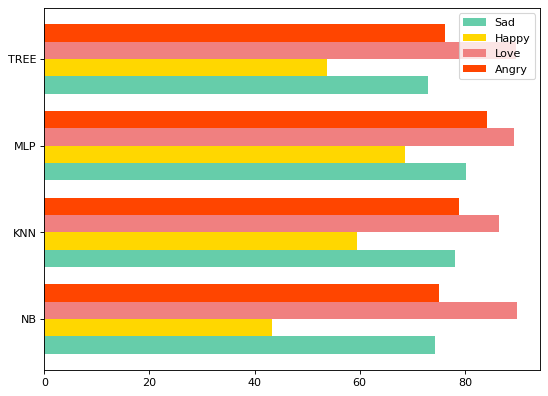

In [36]:
create_compare_f1_graph(experiment1_1)

###### Training:85%     Testing:15%

In [37]:
#GETTING TRAINING AND TESTING SETS
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.15,random_state=42)

In [38]:
y_true, y_pred =naive_bayes(x_train,y_train,x_test,y_test,experiment1_2)

Naive Bayes
accuracy: 70.81339712918661
accuracy by class: [0.7037037  0.90909091 0.37209302 0.77192982]
None f1 score: [0.72380952 0.9009009  0.40506329 0.71544715]
Macro f1 score: 0.6863052175803025
Micro f1 score: 0.7081339712918661
confusion matrix:
[[38 10  4  2]
 [ 5 16  2 20]
 [ 1  4 50  0]
 [ 7  6  0 44]]


In [39]:
y_true, y_pred =knn(x_train,y_train,x_test,y_test,experiment1_2)

K Nearest Neighbors
accuracy: 71.77033492822966
accuracy by class: [0.7962963  0.8        0.55813953 0.68421053]
None f1 score: [0.72881356 0.83809524 0.56470588 0.70909091]
Macro f1 score: 0.7101763972152806
Micro f1 score: 0.7177033492822967
confusion matrix:
[[43  2  4  5]
 [ 8 24  2  9]
 [ 4  7 44  0]
 [ 9  9  0 39]]


In [40]:
y_true, y_pred =mlp(x_train,y_train,x_test,y_test,experiment1_2)

Multilayered Perceptron
accuracy: 81.81818181818183
accuracy by class: [0.83333333 0.90909091 0.65116279 0.84210526]
None f1 score: [0.79646018 0.89285714 0.74666667 0.81355932]
Macro f1 score: 0.8123858271372145
Micro f1 score: 0.8181818181818182
confusion matrix:
[[45  1  5  3]
 [ 4 28  2  9]
 [ 2  2 50  1]
 [ 8  1  0 48]]


In [41]:
y_true, y_pred =tree(x_train,y_train,x_test,y_test,experiment1_2)

Tree Classifier
accuracy: 71.77033492822966
accuracy by class: [0.75925926 0.83636364 0.53488372 0.70175439]
None f1 score: [0.75229358 0.86792453 0.52272727 0.69565217]
Macro f1 score: 0.7096493882309636
Micro f1 score: 0.7177033492822967
confusion matrix:
[[41  7  2  4]
 [ 4 23  2 14]
 [ 2  7 46  0]
 [ 8  8  1 40]]


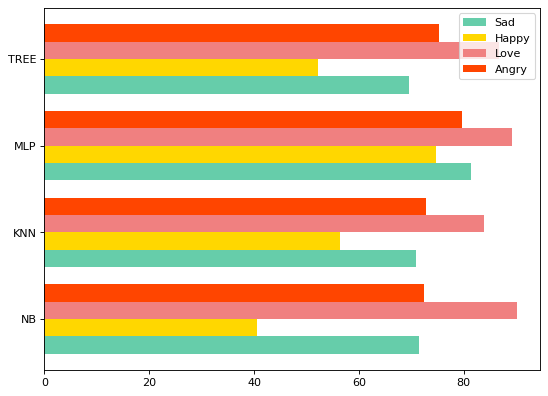

In [42]:
create_compare_f1_graph(experiment1_2)

###### Training:90%     Testing:10%

In [43]:
#GETTING TRAINING AND TESTING SETS
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.10,random_state=42)

In [44]:
y_true, y_pred =naive_bayes(x_train,y_train,x_test,y_test,experiment1_3)

Naive Bayes
accuracy: 67.62589928057554
accuracy by class: [0.71428571 0.875      0.375      0.72727273]
None f1 score: [0.74074074 0.875      0.40677966 0.64864865]
Macro f1 score: 0.6677922626015846
Micro f1 score: 0.6762589928057554
confusion matrix:
[[30  7  3  2]
 [ 4 12  1 15]
 [ 1  3 28  0]
 [ 4  5  0 24]]


In [45]:
y_true, y_pred = knn(x_train,y_train,x_test,y_test,experiment1_3)

K Nearest Neighbors
accuracy: 70.50359712230215
accuracy by class: [0.78571429 0.84375    0.53125    0.63636364]
None f1 score: [0.74157303 0.85714286 0.56666667 0.63636364]
Macro f1 score: 0.7004365484702563
Micro f1 score: 0.7050359712230215
confusion matrix:
[[33  1  3  5]
 [ 7 17  1  7]
 [ 1  4 27  0]
 [ 6  6  0 21]]


In [46]:
y_true, y_pred = mlp(x_train,y_train,x_test,y_test,experiment1_3)

Multilayered Perceptron
accuracy: 82.73381294964028
accuracy by class: [0.9047619  1.         0.59375    0.78787879]
None f1 score: [0.83516484 0.95522388 0.71698113 0.7761194 ]
Macro f1 score: 0.8208723127055991
Micro f1 score: 0.8273381294964028
confusion matrix:
[[38  1  2  1]
 [ 5 19  1  7]
 [ 0  0 32  0]
 [ 6  1  0 26]]


In [47]:
y_true, y_pred = tree(x_train,y_train,x_test,y_test,experiment1_3)

Tree Classifier
accuracy: 70.50359712230215
accuracy by class: [0.78571429 0.9375     0.40625    0.66666667]
None f1 score: [0.75       0.86956522 0.49056604 0.64705882]
Macro f1 score: 0.6892975196641412
Micro f1 score: 0.7050359712230215
confusion matrix:
[[33  3  3  3]
 [ 8 13  2  9]
 [ 0  1 30  1]
 [ 5  4  2 22]]


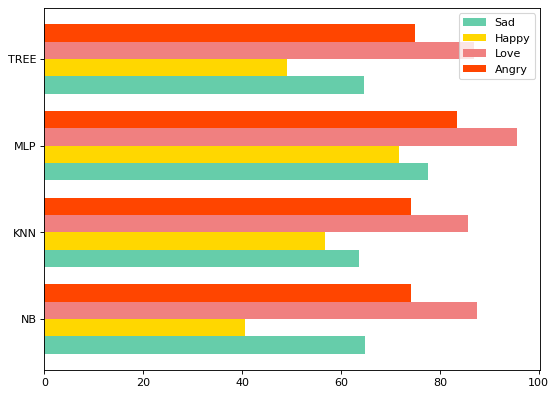

In [48]:
create_compare_f1_graph(experiment1_3)

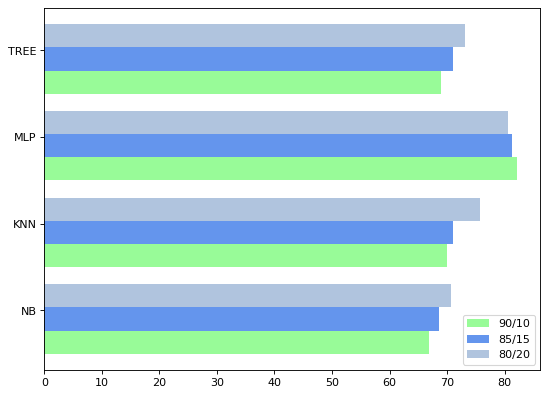

In [49]:

figure(figsize=(8, 6), dpi=80)

experiment3split= [experiment1_3['nb_macro_f1']*100,experiment1_3['knn_macro_f1']*100,
       experiment1_3['mlp_macro_f1']*100, experiment1_3['tree_macro_f1']*100]

experiment2split = [experiment1_2['nb_macro_f1']*100, experiment1_2['knn_macro_f1']*100,
        experiment1_2['mlp_macro_f1']*100, experiment1_2['tree_macro_f1']*100]

experiment1split = [experiment1_1['nb_macro_f1']*100, experiment1_1['knn_macro_f1']*100,
         experiment1_1['mlp_macro_f1']*100, experiment1_1['tree_macro_f1']*100]


height = .267
Pos = np.array(range(4))
plt.barh(Pos , experiment3split, height = height, color = 'palegreen')
plt.barh(Pos + height, experiment2split, height = height, color = 'cornflowerblue')
plt.barh(Pos + height*2, experiment1split, height = height, color = 'lightsteelblue')
plt.yticks(Pos+height+.1, ['NB', 'KNN', 'MLP', 'TREE'])
plt.legend(['90/10','85/15','80/20'])
plt.show()

#top line is 80/20 slplit

In [50]:
print(experiment1_1['mlp_macro_f1'])
print(experiment1_2['mlp_macro_f1'])
print(experiment1_3['mlp_macro_f1'])

0.8061451754316994
0.8123858271372145
0.8208723127055991


mlp performs the best across all splits but does best with 80% training 20% testing and accuracy decreases with 90 10 split, overtraining possible

# Experiment 2: Removing one class

In [51]:
ml_df_with_only_3_classes=ml_df

for i in range(len(ml_df.index)):
    if ml_df_with_only_3_classes['playlist'][i]=='Love':
        ml_df_with_only_3_classes=ml_df_with_only_3_classes.drop([i])

In [52]:
#GETTING TRAINING AND TESTING SETS
x=ml_df_with_only_3_classes.drop('playlist',axis=1)
y=ml_df_with_only_3_classes['playlist']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.15,random_state=42)

target_names = ['Angry','Happy','Sad']

In [53]:
y_true, y_pred = naive_bayes(x_train,y_train,x_test,y_test,experiment2)

Naive Bayes
accuracy: 86.90476190476191
accuracy by class: [0.84375    0.95555556 0.83050847]
None f1 score: [0.8372093  0.92473118 0.85964912]
Macro f1 score: 0.8738632026427661
Micro f1 score: 0.8690476190476191
confusion matrix:
[[ 0  0  0]
 [ 0 43  0]
 [ 0  1 49]]


In [54]:
y_true, y_pred = knn(x_train,y_train,x_test,y_test,experiment2)

K Nearest Neighbors
accuracy: 85.71428571428571
accuracy by class: [0.859375   0.86666667 0.84745763]
None f1 score: [0.85271318 0.85714286 0.86206897]
Macro f1 score: 0.8573083336515573
Micro f1 score: 0.8571428571428571
confusion matrix:
[[ 0  0  0]
 [ 0 39  2]
 [ 0  3 50]]


In [55]:
y_true, y_pred = mlp(x_train,y_train,x_test,y_test,experiment2)

Multilayered Perceptron
accuracy: 88.69047619047619
accuracy by class: [0.921875   0.88888889 0.84745763]
None f1 score: [0.87407407 0.87912088 0.90909091]
Macro f1 score: 0.8874286207619541
Micro f1 score: 0.8869047619047619
confusion matrix:
[[ 0  0  0]
 [ 0 40  0]
 [ 0  2 50]]


In [56]:
y_true, y_pred = tree(x_train,y_train,x_test,y_test,experiment2)

Tree Classifier
accuracy: 89.28571428571429
accuracy by class: [0.875      0.93333333 0.88135593]
None f1 score: [0.90322581 0.88421053 0.88888889]
Macro f1 score: 0.8921084072187638
Micro f1 score: 0.8928571428571429
confusion matrix:
[[ 0  0  0]
 [ 0 42  3]
 [ 0  3 52]]


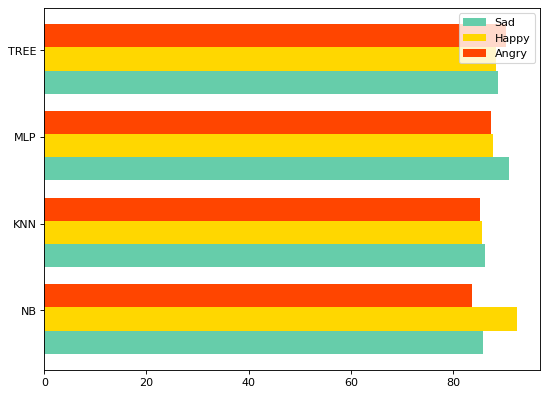

In [57]:
Angry = [experiment2['nb_none_f1'][0]*100, experiment2['knn_none_f1'][0]*100,
         experiment2['mlp_none_f1'][0]*100, experiment2['tree_none_f1'][0]*100]

Happy = [experiment2['nb_none_f1'][1]*100, experiment2['knn_none_f1'][1]*100,
        experiment2['mlp_none_f1'][1]*100, experiment2['tree_none_f1'][1]*100]

Sad = [experiment2['nb_none_f1'][2]*100,experiment2['knn_none_f1'][2]*100,
       experiment2['mlp_none_f1'][2]*100, experiment2['tree_none_f1'][2]*100]


figure(figsize=(8, 6), dpi=80)

height = .267
Pos = np.array(range(4))
plt.barh(Pos , Sad, height = height, color = 'mediumaquamarine')
plt.barh(Pos + height, Happy, height = height, color = 'gold')
plt.barh(Pos + height*2, Angry, height = height, color = 'orangered')
plt.yticks(Pos+height+.1, ['NB', 'KNN', 'MLP', 'TREE'])

plt.legend(['Sad','Happy','Angry'])

plt.show()

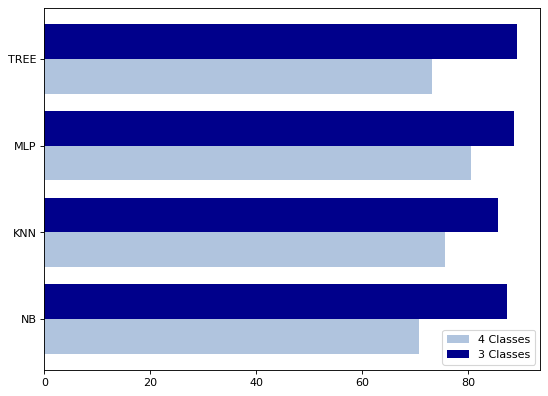

In [58]:

figure(figsize=(8, 6), dpi=80)

classes3 = [experiment2['nb_macro_f1']*100,experiment2['knn_macro_f1']*100,
            experiment2['mlp_macro_f1']*100,experiment2['tree_macro_f1']*100] #topline
classes4 = [experiment1_1['nb_macro_f1']*100, experiment1_1['knn_macro_f1']*100,
         experiment1_1['mlp_macro_f1']*100, experiment1_1['tree_macro_f1']*100]


height = .4
Pos = np.array(range(4))

plt.barh(Pos - (height/2), classes4, height = height, color='lightsteelblue')
plt.barh(Pos + (height/2), classes3, height = height, color='darkblue')

plt.yticks(Pos, ['NB', 'KNN', 'MLP', 'TREE'])

plt.legend(['4 Classes','3 Classes'])

plt.show()

Excellent accuracy but only 3 classes isnt so usefull 

# Experiment 3: Try dropping atributes that are often outliers from box plot these appear to be look like speechiness and instrumentalness

In [59]:
ml_df=ml_df.drop(['speechiness','instrumentalness'],axis=1)


#GETTING TRAINING AND TESTING SETS
x=ml_df.drop('playlist',axis=1)
y=ml_df['playlist']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.15,random_state=42)

target_names = playlist_mood_list

###### NAIVE BAYES

In [60]:
y_true, y_pred = naive_bayes(x_train,y_train,x_test,y_test,experiment3)

Naive Bayes
accuracy: 66.50717703349282
accuracy by class: [0.72222222 0.90909091 0.25581395 0.68421053]
None f1 score: [0.624      0.9009009  0.30985915 0.7027027 ]
Macro f1 score: 0.6343656896332953
Micro f1 score: 0.6650717703349283
confusion matrix:
[[39  9  4  2]
 [17 11  2 13]
 [ 0  5 50  0]
 [15  3  0 39]]


In [61]:
#WRONGLY CLASSIFIED SONGS FOR NAIVE BAYES
wrongly_classified_songs_with_ids=wrongly_classified_songs(y_true,y_pred)
wrongly_classified_songs_with_ids 

index                      id true_mood pred_mood  danceability    energy  \
0      30  6dKcnzld0upEcD5WJINQc6     Anger      Love      0.758420  0.519451   
1      44  4SCQD1e4ULyNyAXvmlZDNk     Anger       Sad      0.732869  0.348970   
2      49  32R92wLWPBtSW0HgSJE1Qv     Anger      Love      0.934959  0.451945   
3      51  4mKXzcEHhm4TAPz9FpN66Z     Anger     Happy      0.876887  0.605263   
4      58  1QRJb5VY3sIkCKcTuIKCrk     Anger      Love      0.551684  0.657895   
..    ...                     ...       ...       ...           ...       ...   
65   1211  6moU77g9RQyMzHNuKEaQKq       Sad     Anger      0.711664  0.549092   
66   1212  6qQ8a6M6o5mfj9wTdrbSgG       Sad     Anger      0.463958  0.574495   
67   1236  4X2caEGywKxXKGImqNkBmt       Sad     Anger      0.631717  0.930141   
68   1277  6nIE1oCE4udqMGv3bqVNVb       Sad     Anger      0.427261  0.867903   
69   1295  7xpraKSakDJ6WWgjQEtvgT       Sad     Anger      0.423329  0.671028   

         key  loudness  mode   valence     tempo  duration_ms  time_signature  \
0   0.636364  0.481242   1.0  0.774047  0.221738     0.118030            0.75   
1   0.363636  0.417873   1.0  0.677964  0.358868     0.511531            0.75   
2   0.454545  0.624210   0.0  0.566044  0.470689     0.336668            0.75   
3   0.090909  0.681116   1.0  0.104635  0.455413     0.199658            0.50   
4   0.090909  0.516863   1.0  0.428783  0.305767     0.302388            1.00   
..       ...       ...   ...       ...       ...          ...             ...   
65  1.000000  0.765171   0.0  0.402222  0.303384     0.472747            0.75   
66  0.181818  0.705582   1.0  0.164444  0.574487     0.496880            0.75   
67  0.727273  0.817371   1.0  0.482222  0.615077     0.434431            0.75   
68  0.000000  0.882252   1.0  0.511111  0.650261     0.375647            0.75   
69  0.090909  0.835439   1.0  0.175556  0.240037     0.528129            0.75   

    acousticness  
0       0.409090  
1       0.670761  
2       0.642506  
3       0.001829  
4       0.007148  
..           ...  
65      0.379455  
66      0.289064  
67      0.616095  
68      0.290080  
69      0.085229  

[70 rows x 14 columns]

In [62]:
#WRONGLY CLASSIFIED SONGS WHICH ARE OUTLIERS
pd.merge(wrongly_classified_songs_with_ids,all_outliers, on='id',how='inner').drop_duplicates()

index                      id true_mood pred_mood  danceability_x  \
0      30  6dKcnzld0upEcD5WJINQc6     Anger      Love        0.758420   
1      44  4SCQD1e4ULyNyAXvmlZDNk     Anger       Sad        0.732869   
2      49  32R92wLWPBtSW0HgSJE1Qv     Anger      Love        0.934959   
3      51  4mKXzcEHhm4TAPz9FpN66Z     Anger     Happy        0.876887   
4      58  1QRJb5VY3sIkCKcTuIKCrk     Anger      Love        0.551684   
..    ...                     ...       ...       ...             ...   
75   1211  6moU77g9RQyMzHNuKEaQKq       Sad     Anger        0.711664   
79   1212  6qQ8a6M6o5mfj9wTdrbSgG       Sad     Anger        0.463958   
81   1236  4X2caEGywKxXKGImqNkBmt       Sad     Anger        0.631717   
83   1277  6nIE1oCE4udqMGv3bqVNVb       Sad     Anger        0.427261   
85   1295  7xpraKSakDJ6WWgjQEtvgT       Sad     Anger        0.423329   

    energy_x     key_x  loudness_x  mode_x  valence_x  ...  loudness_y  \
0   0.519451  0.636364    0.481242     1.0   0.774047  ...        True   
1   0.348970  0.363636    0.417873     1.0   0.677964  ...        True   
2   0.451945  0.454545    0.624210     0.0   0.566044  ...        True   
3   0.605263  0.090909    0.681116     1.0   0.104635  ...        True   
4   0.657895  0.090909    0.516863     1.0   0.428783  ...        True   
..       ...       ...         ...     ...        ...  ...         ...   
75  0.549092  1.000000    0.765171     0.0   0.402222  ...       False   
79  0.574495  0.181818    0.705582     1.0   0.164444  ...       False   
81  0.930141  0.727273    0.817371     1.0   0.482222  ...       False   
83  0.867903  0.000000    0.882252     1.0   0.511111  ...       False   
85  0.671028  0.090909    0.835439     1.0   0.175556  ...       False   

    mode_y  speechiness  instrumentalness  valence_y  tempo_y  duration_ms_y  \
0    False        False             False       True    False          False   
1    False        False             False       True    False           True   
2    False        False             False      False    False          False   
3    False        False             False      False    False          False   
4    False        False             False      False    False          False   
..     ...          ...               ...        ...      ...            ...   
75   False         True              True      False    False          False   
79   False         True              True      False    False          False   
81   False         True              True      False    False          False   
83   False         True              True      False    False          False   
85   False         True              True      False    False          False   

    time_signature_y  acousticness_y  outlier_count  
0               True            True              4  
1               True            True              3  
2               True            True              3  
3               True           False              2  
4               True           False              1  
..               ...             ...            ...  
75             False           False              2  
79             False           False              2  
81             False           False              2  
83             False           False              2  
85             False           False              2  

[65 rows x 27 columns]

###### KNN

In [63]:
y_true, y_pred = knn(x_train,y_train,x_test,y_test,experiment3)

K Nearest Neighbors
accuracy: 72.24880382775119
accuracy by class: [0.81481481 0.83636364 0.46511628 0.71929825]
None f1 score: [0.70967742 0.86792453 0.51948052 0.73873874]
Macro f1 score: 0.7089553014689959
Micro f1 score: 0.722488038277512
confusion matrix:
[[44  5  2  3]
 [10 20  3 10]
 [ 5  4 46  0]
 [11  5  0 41]]


In [64]:
#WRONGLY CLASSIFIED SONGS FOR KNN
wrongly_classified_songs_with_ids=wrongly_classified_songs(y_true,y_pred)
wrongly_classified_songs_with_ids

index                      id true_mood pred_mood  danceability    energy  \
0      29  2huH9q26JmfR0BzV4xKzny     Anger       Sad      0.624855  0.818078   
1      30  6dKcnzld0upEcD5WJINQc6     Anger      Love      0.758420  0.519451   
2      43  4A1qb8RS7awYUVmP0syheX     Anger      Love      0.840883  0.676201   
3      44  4SCQD1e4ULyNyAXvmlZDNk     Anger       Sad      0.732869  0.348970   
4      49  32R92wLWPBtSW0HgSJE1Qv     Anger      Love      0.934959  0.451945   
5      67  3ZhTT6yjZwpPph5MIJ53XY     Anger       Sad      0.662021  0.639588   
6      78  16OlG0GeSYrJZQpDd16i79     Anger     Happy      0.473868  0.759725   
7     111  4OZ6xv8kf3tcmP41f1ZMBg     Anger      Love      0.931475  0.581236   
8     184  7jiiuFE5JSVXoMKov2V1fI     Anger      Love      0.681765  0.654462   
9     371  1OJz2Ko3pWdI2sApQjbFI5     Anger     Happy      0.465738  0.726545   
10    422  3jaUZhLiZOcgoJiGGd3hFD      Love       Sad      0.146233  0.575191   
11    427  5nDSJO4909uNzMcZH3CggS      Love       Sad      0.545052  0.388275   
12    438  709znSutWha3sQdPgdSO00      Love       Sad      0.598227  0.491443   
13    461  5kVkKUQQIMVySlDkGw5MvF      Love       Sad      0.279173  0.201359   
14    471  78TnMTAFmWUWWCgNXR7D3K      Love     Happy      0.548006  0.589756   
15    486  4tCWWnk3BXinf7FllmSyHW      Love       Sad      0.127031  0.347008   
16    493  1UvTPXlImVd4jcucK4qJwb      Love     Anger      0.785820  0.830076   
17    497  4Ny9mteDhBRcTZO9zl0gXW      Love     Anger      0.923191  0.555771   
18    542  047Io7cFZaaVP5CDOy5l6w      Love     Anger      0.856721  0.614031   
19    549  58w68w4s8h9gw3xrDaXyuj      Love       Sad      0.831610  0.469596   
20    552  0jdit0IB5OJbDmPRqadZbs      Love     Anger      0.732644  0.541206   
21    553  5SFssNXGjeOxdAnECfgttm      Love     Anger      0.728213  0.723267   
22    560  3iorjQjhHOPhaSlEXm2eRb      Love     Anger      0.997046  0.229275   
23    570  0mqTcM8kuu2IYPotMt7AzS      Love       Sad      0.577548  0.090909   
24    579  1ckU1EhAO0Nr73QYw24SWJ      Love     Anger      0.889217  0.458672   
25    597  6vrUTGn5p8IrfTZ0J6sIVM      Love     Happy      0.181684  0.841000   
26    602  76qB2ZEZlEJAMqMqUjKusp      Love     Anger      0.519941  0.322733   
27    614  54X78diSLoUDI3joC2bjMz      Love       Sad      0.293944  0.430756   
28    620  0JEqGkvUiMTQmFY6sgL9kg      Love     Anger      0.710487  0.552130   
29    622  7pwTNqKRrJlb0wd476AFO5      Love     Anger      0.933530  0.389489   
30    624  3oEHQmhvFLiE7ZYES0ulzv      Love       Sad      0.384047  0.217138   
31    651  1Wb3DUQg9UDc4kzkQH7WnN      Love       Sad      0.521418  0.044787   
32    669  0815caqt2Lytro5EIzMufT      Love     Happy      0.429838  0.400413   
33    678  5id3Rqn7SPj1LX4FfY4nGz     Happy     Anger      0.308411  0.850158   
34    680  5ow0sNF1zSqp71Ix5jEXWU     Happy      Love      0.523364  0.440063   
35    724  4evmHXcjt3bTUHD1cvny97     Happy     Anger      0.493769  0.488959   
36    745  1fah1uAs7HeTYDlNftKr3K     Happy      Love      0.118380  0.242902   
37    799  2nEdgiHdguBvGmES5Pv4Ca     Happy     Anger      0.870717  0.059937   
38    886  7mnwkU7FlpI3FuSQPmduXf     Happy     Anger      0.515576  0.952681   
39    915  7FS541dJh3iQAEXEZoDhE6     Happy      Love      0.210280  0.730284   
40    963  0K7dHDzNwEAF4kgJUK96Mq     Happy     Anger      0.366044  0.638801   
41    970  05OCY605lOXP7koHNBMPc2     Happy      Love      0.534268  0.152997   
42   1001  6Hj9jySrnFppAI0sEMCZpJ       Sad     Anger      0.650066  0.839959   
43   1039  1TFiDgRvWiHXBvx1vdDa4E       Sad     Anger      0.661861  0.536390   
44   1040  3AJwUDP919kvQ9QcozQPxg       Sad     Anger      0.314548  0.800584   
45   1048  2eY3dm1LBLK7ZoYFwqpSIm       Sad     Anger      0.625164  0.759939   
46   1052  3voz8YdsGn2Y9PXp6xcJkl       Sad     Anger      1.000000  0.406833   
47   1065  07FkzikE6FuHIa8Ma7zJGc       Sad      Love      0.424640  0.800584   
48   1067  27IZXTdeGYjU6m5lTyDpmr  

In [65]:
#WRONGLY CLASSIFIED SONGS WHICH ARE OUTLIERS
pd.merge(wrongly_classified_songs_with_ids,all_outliers, on='id',how='inner').drop_duplicates()

index                      id true_mood pred_mood  danceability_x  \
0      29  2huH9q26JmfR0BzV4xKzny     Anger       Sad        0.624855   
1      30  6dKcnzld0upEcD5WJINQc6     Anger      Love        0.758420   
2      43  4A1qb8RS7awYUVmP0syheX     Anger      Love        0.840883   
3      44  4SCQD1e4ULyNyAXvmlZDNk     Anger       Sad        0.732869   
4      49  32R92wLWPBtSW0HgSJE1Qv     Anger      Love        0.934959   
5      67  3ZhTT6yjZwpPph5MIJ53XY     Anger       Sad        0.662021   
6      78  16OlG0GeSYrJZQpDd16i79     Anger     Happy        0.473868   
7     111  4OZ6xv8kf3tcmP41f1ZMBg     Anger      Love        0.931475   
8     184  7jiiuFE5JSVXoMKov2V1fI     Anger      Love        0.681765   
9     371  1OJz2Ko3pWdI2sApQjbFI5     Anger     Happy        0.465738   
10    422  3jaUZhLiZOcgoJiGGd3hFD      Love       Sad        0.146233   
11    427  5nDSJO4909uNzMcZH3CggS      Love       Sad        0.545052   
12    438  709znSutWha3sQdPgdSO00      Love       Sad        0.598227   
13    461  5kVkKUQQIMVySlDkGw5MvF      Love       Sad        0.279173   
14    471  78TnMTAFmWUWWCgNXR7D3K      Love     Happy        0.548006   
15    486  4tCWWnk3BXinf7FllmSyHW      Love       Sad        0.127031   
16    493  1UvTPXlImVd4jcucK4qJwb      Love     Anger        0.785820   
17    497  4Ny9mteDhBRcTZO9zl0gXW      Love     Anger        0.923191   
18    542  047Io7cFZaaVP5CDOy5l6w      Love     Anger        0.856721   
19    549  58w68w4s8h9gw3xrDaXyuj      Love       Sad        0.831610   
20    552  0jdit0IB5OJbDmPRqadZbs      Love     Anger        0.732644   
21    553  5SFssNXGjeOxdAnECfgttm      Love     Anger        0.728213   
22    560  3iorjQjhHOPhaSlEXm2eRb      Love     Anger        0.997046   
23    570  0mqTcM8kuu2IYPotMt7AzS      Love       Sad        0.577548   
25    579  1ckU1EhAO0Nr73QYw24SWJ      Love     Anger        0.889217   
26    597  6vrUTGn5p8IrfTZ0J6sIVM      Love     Happy        0.181684   
27    602  76qB2ZEZlEJAMqMqUjKusp      Love     Anger        0.519941   
28    614  54X78diSLoUDI3joC2bjMz      Love       Sad        0.293944   
29    620  0JEqGkvUiMTQmFY6sgL9kg      Love     Anger        0.710487   
30    622  7pwTNqKRrJlb0wd476AFO5      Love     Anger        0.933530   
31    624  3oEHQmhvFLiE7ZYES0ulzv      Love       Sad        0.384047   
33    651  1Wb3DUQg9UDc4kzkQH7WnN      Love       Sad        0.521418   
34    669  0815caqt2Lytro5EIzMufT      Love     Happy        0.429838   
35   1001  6Hj9jySrnFppAI0sEMCZpJ       Sad     Anger        0.650066   
37   1039  1TFiDgRvWiHXBvx1vdDa4E       Sad     Anger        0.661861   
39   1040  3AJwUDP919kvQ9QcozQPxg       Sad     Anger        0.314548   
41   1048  2eY3dm1LBLK7ZoYFwqpSIm       Sad     Anger        0.625164   
43   1052  3voz8YdsGn2Y9PXp6xcJkl       Sad     Anger        1.000000   
45   1065  07FkzikE6FuHIa8Ma7zJGc       Sad      Love        0.424640   
47   1067  27IZXTdeGYjU6m5lTyDpmr       Sad     Anger        0.169069   
49   1070  62Z8KVNDZoaf8emKTO2nQt       Sad     Anger        0.609436   
51   1088  1uNiqZnW9OmhumrtYiClYN       Sad     Anger        0.748362   
53   1146  53bCcVMGv0S2aIYvfju2Tt       Sad      Love        0.359109   
55   1155  1eGOABsA0NdhU6LiLQzhWe       Sad      Love        0.668414   
57   1193  6sHxpnCerm9M6A5zaFFNfs       Sad     Anger        0.167759   
59   1211  6moU77g9RQyMzHNuKEaQKq       Sad     Anger        0.711664   
63   1212  6qQ8a6M6o5mfj9wTdrbSgG       Sad      Love        0.463958   
65   1295  7xpraKSakDJ6WWgjQEtvgT       Sad     Anger        0.423329   
67   1374  7BZSIG9TyowrVzSdZJpmeI       Sad      Love        0.457405   

    energy_x     key_x  loudness_x  mode_x  valence_x  ...  loudness_y  \
0   0.818078  0.181818    0.740548     1.0   0.628339  ...        True   
1   0.519451  0.636364    0.481242     1.0   0.774047  ...        True   
2   0.676201  0.000000    0.655749     1.0   0.885968  ...        True   
3   0.348970  0.363636    0.417873     1.0   0.677964  ..

###### MLP

In [66]:
y_true, y_pred = mlp(x_train,y_train,x_test,y_test,experiment3)

Multilayered Perceptron
accuracy: 79.90430622009569
accuracy by class: [0.81481481 0.92727273 0.62790698 0.78947368]
None f1 score: [0.77876106 0.91071429 0.6835443  0.78947368]
Macro f1 score: 0.7906233339172957
Micro f1 score: 0.7990430622009569
confusion matrix:
[[44  3  3  4]
 [ 5 27  3  8]
 [ 3  1 51  0]
 [ 7  5  0 45]]


In [67]:
#WRONGLY CLASSIFIED SONGS FOR MLP
wrongly_classified_songs_with_ids=wrongly_classified_songs(y_true,y_pred)
wrongly_classified_songs_with_ids

index                      id true_mood pred_mood  danceability    energy  \
0      29  2huH9q26JmfR0BzV4xKzny     Anger       Sad      0.624855  0.818078   
1      30  6dKcnzld0upEcD5WJINQc6     Anger      Love      0.758420  0.519451   
2      43  4A1qb8RS7awYUVmP0syheX     Anger      Love      0.840883  0.676201   
3      44  4SCQD1e4ULyNyAXvmlZDNk     Anger       Sad      0.732869  0.348970   
4      51  4mKXzcEHhm4TAPz9FpN66Z     Anger     Happy      0.876887  0.605263   
5      78  16OlG0GeSYrJZQpDd16i79     Anger     Happy      0.473868  0.759725   
6     111  4OZ6xv8kf3tcmP41f1ZMBg     Anger      Love      0.931475  0.581236   
7     184  7jiiuFE5JSVXoMKov2V1fI     Anger       Sad      0.681765  0.654462   
8     342  57Y16Yl1Ocu9WC837zQJz1     Anger       Sad      0.713124  0.979405   
9     346  0yixjYe37Uhlf1dupqplkh     Anger     Happy      0.403020  0.977117   
10    422  3jaUZhLiZOcgoJiGGd3hFD      Love       Sad      0.146233  0.575191   
11    438  709znSutWha3sQdPgdSO00      Love       Sad      0.598227  0.491443   
12    461  5kVkKUQQIMVySlDkGw5MvF      Love       Sad      0.279173  0.201359   
13    471  78TnMTAFmWUWWCgNXR7D3K      Love       Sad      0.548006  0.589756   
14    486  4tCWWnk3BXinf7FllmSyHW      Love     Happy      0.127031  0.347008   
15    493  1UvTPXlImVd4jcucK4qJwb      Love     Anger      0.785820  0.830076   
16    497  4Ny9mteDhBRcTZO9zl0gXW      Love     Anger      0.923191  0.555771   
17    553  5SFssNXGjeOxdAnECfgttm      Love     Anger      0.728213  0.723267   
18    567  2J1t1HhcO5sxYBrCKnEdF9      Love       Sad      0.254062  0.399199   
19    579  1ckU1EhAO0Nr73QYw24SWJ      Love     Anger      0.889217  0.458672   
20    591  225xvV8r1yKMHErSWivnow      Love       Sad      0.317578  0.685641   
21    597  6vrUTGn5p8IrfTZ0J6sIVM      Love     Happy      0.181684  0.841000   
22    614  54X78diSLoUDI3joC2bjMz      Love       Sad      0.293944  0.430756   
23    622  7pwTNqKRrJlb0wd476AFO5      Love     Anger      0.933530  0.389489   
24    651  1Wb3DUQg9UDc4kzkQH7WnN      Love       Sad      0.521418  0.044787   
25    669  0815caqt2Lytro5EIzMufT      Love     Happy      0.429838  0.400413   
26    678  5id3Rqn7SPj1LX4FfY4nGz     Happy     Anger      0.308411  0.850158   
27    680  5ow0sNF1zSqp71Ix5jEXWU     Happy      Love      0.523364  0.440063   
28    799  2nEdgiHdguBvGmES5Pv4Ca     Happy     Anger      0.870717  0.059937   
29    824  0lNv90Wo1lnE9GZSJslOvj     Happy     Anger      0.431464  0.888013   
30   1001  6Hj9jySrnFppAI0sEMCZpJ       Sad     Anger      0.650066  0.839959   
31   1039  1TFiDgRvWiHXBvx1vdDa4E       Sad     Anger      0.661861  0.536390   
32   1040  3AJwUDP919kvQ9QcozQPxg       Sad     Anger      0.314548  0.800584   
33   1048  2eY3dm1LBLK7ZoYFwqpSIm       Sad     Anger      0.625164  0.759939   
34   1052  3voz8YdsGn2Y9PXp6xcJkl       Sad     Anger      1.000000  0.406833   
35   1088  1uNiqZnW9OmhumrtYiClYN       Sad     Anger      0.748362  0.984758   
36   1111  7F1CiKqrY44kh5cDqwHOnx       Sad      Love      0.461337  0.155341   
37   1125  137mSruegm1u6x9NvwiagR       Sad      Love      0.401048  0.383971   
38   1155  1eGOABsA0NdhU6LiLQzhWe       Sad      Love      0.668414  0.103264   
39   1187  5c1gKtJkR8dPjki25BU7Qz       Sad      Love      0.356488  0.535120   
40   1204  13TMuxC8tdSfthXpHG9D26       Sad      Love      0.517693  0.494475   
41   1236  4X2caEGywKxXKGImqNkBmt       Sad     Anger      0.631717  0.930141   

         key  loudness  mode   valence     tempo  duration_ms  time_signature  \
0   0.181818  0.740548   1.0  0.628339  0.395302     0.539681            0.75   
1   0.636364  0.481242   1.0  0.774047  0.221738     0.118030            0.75   
2   0.000000  0.655749   1.0  0.885968  0.328520     0.069985            0.75   
3   0.363636  0.417873   1.0  0.677964  0.358868     0.511531            0.75   
4   0.090909  0.681116   1.0  0.104635  0.455413     0.199658            0.50   
5   0.363636  0.589950   0.0  0.40

In [68]:
#WRONGLY CLASSIFIED SONGS WHICH ARE OUTLIERS
pd.merge(wrongly_classified_songs_with_ids,all_outliers, on='id',how='inner').drop_duplicates()

index                      id true_mood pred_mood  danceability_x  \
0      29  2huH9q26JmfR0BzV4xKzny     Anger       Sad        0.624855   
1      30  6dKcnzld0upEcD5WJINQc6     Anger      Love        0.758420   
2      43  4A1qb8RS7awYUVmP0syheX     Anger      Love        0.840883   
3      44  4SCQD1e4ULyNyAXvmlZDNk     Anger       Sad        0.732869   
4      51  4mKXzcEHhm4TAPz9FpN66Z     Anger     Happy        0.876887   
5      78  16OlG0GeSYrJZQpDd16i79     Anger     Happy        0.473868   
6     111  4OZ6xv8kf3tcmP41f1ZMBg     Anger      Love        0.931475   
7     184  7jiiuFE5JSVXoMKov2V1fI     Anger       Sad        0.681765   
8     342  57Y16Yl1Ocu9WC837zQJz1     Anger       Sad        0.713124   
9     346  0yixjYe37Uhlf1dupqplkh     Anger     Happy        0.403020   
10    422  3jaUZhLiZOcgoJiGGd3hFD      Love       Sad        0.146233   
11    438  709znSutWha3sQdPgdSO00      Love       Sad        0.598227   
12    461  5kVkKUQQIMVySlDkGw5MvF      Love       Sad        0.279173   
13    471  78TnMTAFmWUWWCgNXR7D3K      Love       Sad        0.548006   
14    486  4tCWWnk3BXinf7FllmSyHW      Love     Happy        0.127031   
15    493  1UvTPXlImVd4jcucK4qJwb      Love     Anger        0.785820   
16    497  4Ny9mteDhBRcTZO9zl0gXW      Love     Anger        0.923191   
17    553  5SFssNXGjeOxdAnECfgttm      Love     Anger        0.728213   
18    567  2J1t1HhcO5sxYBrCKnEdF9      Love       Sad        0.254062   
19    579  1ckU1EhAO0Nr73QYw24SWJ      Love     Anger        0.889217   
20    591  225xvV8r1yKMHErSWivnow      Love       Sad        0.317578   
21    597  6vrUTGn5p8IrfTZ0J6sIVM      Love     Happy        0.181684   
22    614  54X78diSLoUDI3joC2bjMz      Love       Sad        0.293944   
23    622  7pwTNqKRrJlb0wd476AFO5      Love     Anger        0.933530   
24    651  1Wb3DUQg9UDc4kzkQH7WnN      Love       Sad        0.521418   
25    669  0815caqt2Lytro5EIzMufT      Love     Happy        0.429838   
26   1001  6Hj9jySrnFppAI0sEMCZpJ       Sad     Anger        0.650066   
28   1039  1TFiDgRvWiHXBvx1vdDa4E       Sad     Anger        0.661861   
30   1040  3AJwUDP919kvQ9QcozQPxg       Sad     Anger        0.314548   
32   1048  2eY3dm1LBLK7ZoYFwqpSIm       Sad     Anger        0.625164   
34   1052  3voz8YdsGn2Y9PXp6xcJkl       Sad     Anger        1.000000   
36   1088  1uNiqZnW9OmhumrtYiClYN       Sad     Anger        0.748362   
38   1111  7F1CiKqrY44kh5cDqwHOnx       Sad      Love        0.461337   
40   1125  137mSruegm1u6x9NvwiagR       Sad      Love        0.401048   
42   1155  1eGOABsA0NdhU6LiLQzhWe       Sad      Love        0.668414   
44   1187  5c1gKtJkR8dPjki25BU7Qz       Sad      Love        0.356488   
46   1204  13TMuxC8tdSfthXpHG9D26       Sad      Love        0.517693   
48   1236  4X2caEGywKxXKGImqNkBmt       Sad     Anger        0.631717   

    energy_x     key_x  loudness_x  mode_x  valence_x  ...  loudness_y  \
0   0.818078  0.181818    0.740548     1.0   0.628339  ...        True   
1   0.519451  0.636364    0.481242     1.0   0.774047  ...        True   
2   0.676201  0.000000    0.655749     1.0   0.885968  ...        True   
3   0.348970  0.363636    0.417873     1.0   0.677964  ...        True   
4   0.605263  0.090909    0.681116     1.0   0.104635  ...        True   
5   0.759725  0.363636    0.589950     0.0   0.400275  ...        True   
6   0.581236  0.181818    0.690835     0.0   0.878577  ...        True   
7   0.654462  0.090909    0.630868     1.0   0.753986  ...        True   
8   0.979405  0.000000    0.933473     0.0   0.391828  ...        True   
9   0.977117  1.000000    0.912091     1.0   0.375990  ...        True   
10  0.575191  0.000000    0.848330     1.0   0.290238  ...       False   
11  0.491443  0.181818    0.778458     1.0   0.250928  ...       False   
12  0.201359  0.272727    0.432947     0.0   0.242193  ...       False   
13  0.589756  0.090909    0.905735     0.0   0.326272  ...       False   
14  0.347008  0.181818    0.737641     1.0   0

###### TREE CLASSIFIER

In [69]:
y_true, y_pred = tree(x_train,y_train,x_test,y_test,experiment3)

Tree Classifier
accuracy: 72.72727272727273
accuracy by class: [0.75925926 0.89090909 0.48837209 0.71929825]
None f1 score: [0.75925926 0.89908257 0.5        0.7008547 ]
Macro f1 score: 0.7147991322303249
Micro f1 score: 0.7272727272727273
confusion matrix:
[[41  6  2  5]
 [ 7 21  2 13]
 [ 1  4 49  1]
 [ 5 10  1 41]]


In [70]:
#WRONGLY CLASSIFIED SONGS FOR TREE CLASSIFIER
wrongly_classified_songs_with_ids=wrongly_classified_songs(y_true,y_pred)
wrongly_classified_songs_with_ids

index                      id true_mood pred_mood  danceability    energy  \
0      43  4A1qb8RS7awYUVmP0syheX     Anger      Love      0.840883  0.676201   
1      44  4SCQD1e4ULyNyAXvmlZDNk     Anger     Happy      0.732869  0.348970   
2      49  32R92wLWPBtSW0HgSJE1Qv     Anger       Sad      0.934959  0.451945   
3      51  4mKXzcEHhm4TAPz9FpN66Z     Anger      Love      0.876887  0.605263   
4      67  3ZhTT6yjZwpPph5MIJ53XY     Anger       Sad      0.662021  0.639588   
5      78  16OlG0GeSYrJZQpDd16i79     Anger     Happy      0.473868  0.759725   
6     111  4OZ6xv8kf3tcmP41f1ZMBg     Anger      Love      0.931475  0.581236   
7     168  6XMQ6E2hldP4CqWVparRce     Anger       Sad      0.917538  0.616705   
8     184  7jiiuFE5JSVXoMKov2V1fI     Anger       Sad      0.681765  0.654462   
9     239  2XhJpVPyqhDU0EPDAIBpwe     Anger      Love      0.000000  0.981693   
10    346  0yixjYe37Uhlf1dupqplkh     Anger       Sad      0.403020  0.977117   
11    367  0Zp0l6SKUOX3LV3MceJzNX     Anger      Love      0.394890  1.000000   
12    371  1OJz2Ko3pWdI2sApQjbFI5     Anger      Love      0.465738  0.726545   
13    422  3jaUZhLiZOcgoJiGGd3hFD      Love       Sad      0.146233  0.575191   
14    428  2A6yzRGMgSQCUapR2ptm6A      Love       Sad      0.338257  0.133390   
15    429  622nEHkm52E6ijVShcea9f      Love       Sad      0.446086  0.158879   
16    438  709znSutWha3sQdPgdSO00      Love       Sad      0.598227  0.491443   
17    439  1JLn8RhQzHz3qDqsChcmBl      Love     Anger      0.456425  0.453817   
18    451  1VI7sH93UcY0stZYVqvMoH      Love       Sad      0.711965  0.336084   
19    461  5kVkKUQQIMVySlDkGw5MvF      Love       Sad      0.279173  0.201359   
20    471  78TnMTAFmWUWWCgNXR7D3K      Love       Sad      0.548006  0.589756   
21    482  46n2EGFnPC3tzWCN1Aqe26      Love       Sad      0.564254  0.594611   
22    486  4tCWWnk3BXinf7FllmSyHW      Love       Sad      0.127031  0.347008   
23    493  1UvTPXlImVd4jcucK4qJwb      Love     Anger      0.785820  0.830076   
24    497  4Ny9mteDhBRcTZO9zl0gXW      Love     Anger      0.923191  0.555771   
25    549  58w68w4s8h9gw3xrDaXyuj      Love       Sad      0.831610  0.469596   
26    553  5SFssNXGjeOxdAnECfgttm      Love     Anger      0.728213  0.723267   
27    567  2J1t1HhcO5sxYBrCKnEdF9      Love       Sad      0.254062  0.399199   
28    591  225xvV8r1yKMHErSWivnow      Love       Sad      0.317578  0.685641   
29    597  6vrUTGn5p8IrfTZ0J6sIVM      Love     Happy      0.181684  0.841000   
30    614  54X78diSLoUDI3joC2bjMz      Love     Anger      0.293944  0.430756   
31    618  5DeXQ3qADuDmqsosnZAK3o      Love     Anger      0.460857  0.524214   
32    622  7pwTNqKRrJlb0wd476AFO5      Love     Anger      0.933530  0.389489   
33    651  1Wb3DUQg9UDc4kzkQH7WnN      Love       Sad      0.521418  0.044787   
34    669  0815caqt2Lytro5EIzMufT      Love     Happy      0.429838  0.400413   
35    693  6Tio0ZoDeSQnI7EBAqWer2     Happy      Love      0.238318  0.403785   
36    745  1fah1uAs7HeTYDlNftKr3K     Happy      Love      0.118380  0.242902   
37    811  1RXzKs0tQcn7CeI6w34REK     Happy     Anger      0.657321  0.932177   
38    865  58R30o2zynpgdvG5Nxfur8     Happy      Love      0.257009  0.413249   
39    901  1WR8eDyLw7uW5KDv7Sr50h     Happy       Sad      0.727414  0.260252   
40    970  05OCY605lOXP7koHNBMPc2     Happy      Love      0.534268  0.152997   
41   1048  2eY3dm1LBLK7ZoYFwqpSIm       Sad     Anger      0.625164  0.759939   
42   1052  3voz8YdsGn2Y9PXp6xcJkl       Sad      Love      1.000000  0.406833   
43   1061  0JnSoyZMTYZLWFVdVT1JFZ       Sad      Love      0.366972  0.062619   
44   1067  27IZXTdeGYjU6m5lTyDpmr       Sad     Anger      0.169069  0.926330   
45   1070  62Z8KVNDZoaf8emKTO2nQt       Sad      Love      0.609436  0.672298   
46   1088  1uNiqZnW9OmhumrtYiClYN       Sad     Anger      0.748362  0.984758   
47   1125  137mSruegm1u6x9NvwiagR       Sad      Love      0.401048  0.383971   
48   1146  53bCcVMGv0S2aIYvfju2Tt  

In [71]:
#WRONGLY CLASSIFIED SONGS WHICH ARE OUTLIERS
pd.merge(wrongly_classified_songs_with_ids,all_outliers, on='id',how='inner').drop_duplicates()

index                      id true_mood pred_mood  danceability_x  \
0      43  4A1qb8RS7awYUVmP0syheX     Anger      Love        0.840883   
1      44  4SCQD1e4ULyNyAXvmlZDNk     Anger     Happy        0.732869   
2      49  32R92wLWPBtSW0HgSJE1Qv     Anger       Sad        0.934959   
3      51  4mKXzcEHhm4TAPz9FpN66Z     Anger      Love        0.876887   
4      67  3ZhTT6yjZwpPph5MIJ53XY     Anger       Sad        0.662021   
5      78  16OlG0GeSYrJZQpDd16i79     Anger     Happy        0.473868   
6     111  4OZ6xv8kf3tcmP41f1ZMBg     Anger      Love        0.931475   
7     168  6XMQ6E2hldP4CqWVparRce     Anger       Sad        0.917538   
8     184  7jiiuFE5JSVXoMKov2V1fI     Anger       Sad        0.681765   
9     239  2XhJpVPyqhDU0EPDAIBpwe     Anger      Love        0.000000   
10    346  0yixjYe37Uhlf1dupqplkh     Anger       Sad        0.403020   
11    367  0Zp0l6SKUOX3LV3MceJzNX     Anger      Love        0.394890   
12    371  1OJz2Ko3pWdI2sApQjbFI5     Anger      Love        0.465738   
13    422  3jaUZhLiZOcgoJiGGd3hFD      Love       Sad        0.146233   
14    428  2A6yzRGMgSQCUapR2ptm6A      Love       Sad        0.338257   
15    429  622nEHkm52E6ijVShcea9f      Love       Sad        0.446086   
16    438  709znSutWha3sQdPgdSO00      Love       Sad        0.598227   
17    439  1JLn8RhQzHz3qDqsChcmBl      Love     Anger        0.456425   
18    451  1VI7sH93UcY0stZYVqvMoH      Love       Sad        0.711965   
19    461  5kVkKUQQIMVySlDkGw5MvF      Love       Sad        0.279173   
20    471  78TnMTAFmWUWWCgNXR7D3K      Love       Sad        0.548006   
21    482  46n2EGFnPC3tzWCN1Aqe26      Love       Sad        0.564254   
22    486  4tCWWnk3BXinf7FllmSyHW      Love       Sad        0.127031   
23    493  1UvTPXlImVd4jcucK4qJwb      Love     Anger        0.785820   
24    497  4Ny9mteDhBRcTZO9zl0gXW      Love     Anger        0.923191   
25    549  58w68w4s8h9gw3xrDaXyuj      Love       Sad        0.831610   
26    553  5SFssNXGjeOxdAnECfgttm      Love     Anger        0.728213   
27    567  2J1t1HhcO5sxYBrCKnEdF9      Love       Sad        0.254062   
28    591  225xvV8r1yKMHErSWivnow      Love       Sad        0.317578   
29    597  6vrUTGn5p8IrfTZ0J6sIVM      Love     Happy        0.181684   
30    614  54X78diSLoUDI3joC2bjMz      Love     Anger        0.293944   
31    618  5DeXQ3qADuDmqsosnZAK3o      Love     Anger        0.460857   
32    622  7pwTNqKRrJlb0wd476AFO5      Love     Anger        0.933530   
33    651  1Wb3DUQg9UDc4kzkQH7WnN      Love       Sad        0.521418   
34    669  0815caqt2Lytro5EIzMufT      Love     Happy        0.429838   
35   1048  2eY3dm1LBLK7ZoYFwqpSIm       Sad     Anger        0.625164   
37   1052  3voz8YdsGn2Y9PXp6xcJkl       Sad      Love        1.000000   
39   1061  0JnSoyZMTYZLWFVdVT1JFZ       Sad      Love        0.366972   
41   1067  27IZXTdeGYjU6m5lTyDpmr       Sad     Anger        0.169069   
43   1070  62Z8KVNDZoaf8emKTO2nQt       Sad      Love        0.609436   
45   1088  1uNiqZnW9OmhumrtYiClYN       Sad     Anger        0.748362   
47   1125  137mSruegm1u6x9NvwiagR       Sad      Love        0.401048   
49   1146  53bCcVMGv0S2aIYvfju2Tt       Sad      Love        0.359109   
51   1155  1eGOABsA0NdhU6LiLQzhWe       Sad     Happy        0.668414   
53   1177  1lCgCLr0V3xh6TtQTNvdfn       Sad      Love        0.387942   
55   1204  13TMuxC8tdSfthXpHG9D26       Sad      Love        0.517693   
57   1212  6qQ8a6M6o5mfj9wTdrbSgG       Sad      Love        0.463958   
59   1221  1SoR3NCP3P9dtdoTnpPNi1       Sad      Love        0.474443   
61   1277  6nIE1oCE4udqMGv3bqVNVb       Sad     Anger        0.427261   
63   1292  0UkZ0epPTahsPgLXacC5EG       Sad      Love        0.343381   
65   1374  7BZSIG9TyowrVzSdZJpmeI       Sad     Anger        0.457405   

    energy_x     key_x  loudness_x  mode_x  valence_x  ...  loudness_y  \
0   0.676201  0.000000    0.655749     1.0   0.885968  ...        True   
1   0.348970  0.363636    0.417873     1.0   0.677964  ... 

From what I can tell the outliers dont seem more wrongly classified than songs that are not outliers. And removing speechiness and instramentalness does not increase accuracy.

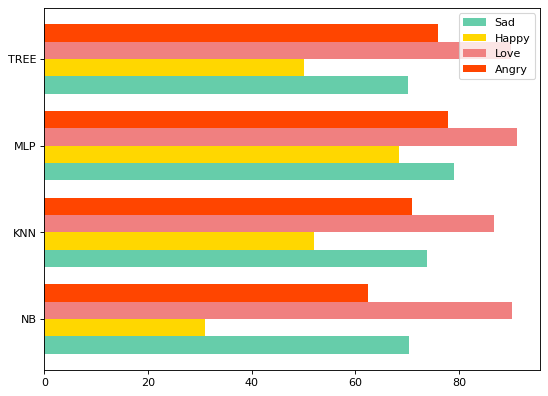

In [72]:
create_compare_f1_graph(experiment3)

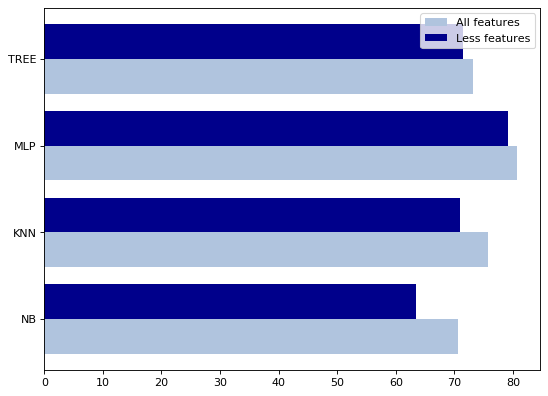

In [73]:

figure(figsize=(8, 6), dpi=80)
less_features = [experiment3['nb_macro_f1']*100,experiment3['knn_macro_f1']*100,
            experiment3['mlp_macro_f1']*100,experiment3['tree_macro_f1']*100] #topline
all_features = [experiment1_1['nb_macro_f1']*100, experiment1_1['knn_macro_f1']*100,
         experiment1_1['mlp_macro_f1']*100, experiment1_1['tree_macro_f1']*100]


height = .4
Pos = np.array(range(4))

plt.barh(Pos - (height/2), all_features, height = height, color='lightsteelblue')
plt.barh(Pos + (height/2), less_features, height = height, color='darkblue')

plt.yticks(Pos, ['NB', 'KNN', 'MLP', 'TREE'])

plt.legend(['All features','Less features'])

plt.show()

# Experiment 4: removing outliers (after the removal of instrumentalness and speechiness as they are almost always outliers)

In [74]:
all_outliers_less_features=all_outliers.drop(['speechiness','instrumentalness'],axis=1)

In [75]:
#adding a row with the number of outlier features for each song
all_outliers_less_features['outlier_count']=0

    
for i in range(len(all_outliers_less_features.index)): 
    
        outlier_feature_count=0

        if all_outliers_less_features.loc[i]['danceability']== True: 
            outlier_feature_count=outlier_feature_count+1
        if all_outliers_less_features.loc[i]['energy']==True:
            outlier_feature_count=outlier_feature_count+1
        if all_outliers_less_features.loc[i]['loudness']== True: 
            outlier_feature_count=outlier_feature_count+1
        if all_outliers_less_features.loc[i]['acousticness']==True:
            outlier_feature_count=outlier_feature_count+1
        if all_outliers_less_features.loc[i]['valence']==True:
            outlier_feature_count=outlier_feature_count+1
        if all_outliers_less_features.loc[i]['tempo']==True:
            outlier_feature_count=outlier_feature_count+1

        all_outliers_less_features['outlier_count'][i]=outlier_feature_count

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [76]:
#get all songs that are not outliers at all
not_outliers=all_outliers_less_features[all_outliers_less_features['outlier_count']<1]

###### Remove outliers

In [77]:
not_outliers=not_outliers.drop(['danceability','energy','acousticness','valence','tempo','outlier_count','loudness'],axis=1)

In [78]:
#getting songs together with their ids
ml_df_with_ids=pd.concat([ml_df,playlists_songs_ids],axis=1)
#get the songs that are not outliers with their features
ml_df_no_outliers=pd.merge(ml_df_with_ids,not_outliers,on='id',how='inner')
#get rid of index and id
#ml_df_no_outliers=ml_df_no_outliers.drop(['index','id'],axis=1)
ml_df_no_outliers=ml_df_no_outliers.drop(['id'],axis=1)
#get rid of nulls
ml_df_no_outliers=ml_df_no_outliers.dropna()
# drop 

In [79]:
#get training test split
x=ml_df_no_outliers.drop(['playlist','key_y','mode_y','duration_ms_y','time_signature_y'], axis=1)
y=ml_df_no_outliers['playlist']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.15,random_state=42)

target_names = playlist_mood_list

In [80]:
y_true, y_pred = naive_bayes(x_train,y_train,x_test,y_test,experiment4)

Naive Bayes
accuracy: 80.0
accuracy by class: [0.48979592 0.93693694]
None f1 score: [0.6        0.86666667]
Macro f1 score: 0.7333333333333334
Micro f1 score: 0.8000000000000002
confusion matrix:
[[  0   0   0   0]
 [  0  24   0  25]
 [  0   0   0   0]
 [  0   7   0 104]]


In [81]:
y_true, y_pred = knn(x_train,y_train,x_test,y_test,experiment4)

K Nearest Neighbors
accuracy: 88.125
accuracy by class: [0.67346939 0.97297297]
None f1 score: [0.77647059 0.91914894]
Macro f1 score: 0.8478097622027534
Micro f1 score: 0.88125
confusion matrix:
[[  0   0   0   0]
 [  0  33   0  16]
 [  0   0   0   0]
 [  0   3   0 108]]


In [82]:
y_true, y_pred = mlp(x_train,y_train,x_test,y_test,experiment4)

Multilayered Perceptron
accuracy: 89.375
accuracy by class: [0.79591837 0.93693694]
None f1 score: [0.82105263 0.92444444]
Macro f1 score: 0.8727485380116958
Micro f1 score: 0.89375
confusion matrix:
[[  0   0   0   0]
 [  0  39   0  10]
 [  0   0   0   0]
 [  0   7   0 104]]


In [83]:
y_true, y_pred = tree(x_train,y_train,x_test,y_test,experiment4)

Tree Classifier
accuracy: 91.875
accuracy by class: [       nan 0.7755102  0.98198198]
None f1 score: [0.         0.85393258 0.95196507]
Macro f1 score: 0.6019658832572821
Micro f1 score: 0.91875
confusion matrix:
[[  0   0   0   0]
 [  2  38   0   9]
 [  0   0   0   0]
 [  0   2   0 109]]


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


### It seems like all of one class is gone

In [84]:
ml_df_no_outliers=ml_df_no_outliers.reset_index()

In [85]:
angry_count=0
love_count=0
sad_count=0
happy_count=0

for i in range(len(ml_df_no_outliers.index)):
    if ml_df_no_outliers['playlist'][i]=='Angry':
        angry_count=angry_count+1
    if ml_df_no_outliers['playlist'][i]=='Love':
        love_count=love_count+1 
    if ml_df_no_outliers['playlist'][i]=='Happy':
        happy_count=happy_count+1
    if ml_df_no_outliers['playlist'][i]=='Sad':
        sad_count=sad_count+1
   
        
print('angry: '+ str(angry_count))
print('love: '+ str(love_count))
print('happy: '+ str(happy_count))
print('sad: '+ str(sad_count))

angry: 0
love: 299
happy: 1
sad: 762


It looks like angry and happy songs are often, if not always, outliers

######  Naive bayes does not seem to do well, probably because of its naive assumption that features are indpenedant

In [86]:
import plotly.express as px

fig = px.scatter(ml_df, x = 'danceability',
                  y = 'valence',
                  color='valence',
                  hover_data=['energy'])

fig.show()

## Playlist creation with best performing classifer

Here I'm trying to answer the question can a less than perfect classifer give good recommendations?

The best performing classifer seems to be mlp using all features and the training testing split of 85/15, so this is the one I will used to classify my 'user data' that I already collected and see how it does.

In [87]:
#set environmental variables
# MUST BE FILLED IN CLIENT_ID AND CLIENT_SECRET 
os.environ['SPOTIPY_CLIENT_ID'] =''
os.environ['SPOTIPY_CLIENT_SECRET'] = ''
os.environ['SPOTIPY_REDIRECT_URI'] = 'http://localhost:8080'

In [88]:
#get names of playlists and their songs
scope = 'user-library-read'


sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

#this function has limit 50 playlists
playlists = sp.current_user_playlists()

#make empty dataframe with id and name
all_playlist_songs_df=pd.DataFrame(columns=['id','name'])

for playlist in range(playlists['total']):
    for song in range(sp.playlist(playlists['items'][playlist]['id'])['tracks']['total']):
        all_playlist_songs_df=all_playlist_songs_df.append(
            {
            'id':sp.playlist(playlists['items'][playlist]['id'])['tracks']['items'][song]['track']['id'],
            'name':sp.playlist(playlists['items'][playlist]['id'])['tracks']['items'][song]['track']['name']
            },ignore_index=True)
        


In [90]:
#get all liked songs (saved songs)
scope = 'user-library-read'

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

saved_tracks_df=pd.DataFrame(columns = ['album','artists','id','name','popularity'])
results = sp.current_user_saved_tracks(limit=20,offset=0) # to get the number of songs because function has set limit 20

total_tracks=results['total']

if(total_tracks<20):    
    results = sp.current_user_saved_tracks(limit=20,offset=0) # to get the number of songs because function has set limit 20

    for i in range(0,tracks,1):
        saved_tracks_df=saved_tracks_df.append({'album': results['items'][i]['track']['album'],
                                                'artists':results['items'][i]['track']['artists'],
                                                'id':results['items'][i]['track']['id'],
                                                'name':results['items'][i]['track']['name'],
                                                'popularity':results['items'][i]['track']['popularity']},
                                                ignore_index=True)
    
else:
    shift=0
    number_songs_gotten=0
    for i in range(math.ceil(total_tracks/20)):

            results = sp.current_user_saved_tracks(limit=20,offset=shift)

            if(total_tracks-number_songs_gotten<20):
                for j in range(total_tracks-number_songs_gotten):
                    saved_tracks_df=saved_tracks_df.append({'album': results['items'][i]['track']['album'],
                                                            'artists':results['items'][i]['track']['artists'],
                                                            'id':results['items'][i]['track']['id'],
                                                            'name':results['items'][i]['track']['name'],
                                                            'popularity':results['items'][i]['track']['popularity']},
                                                                ignore_index=True)
            else:
                for j in range(20):
                    saved_tracks_df=saved_tracks_df.append({'album': results['items'][i]['track']['album'],
                                                            'artists':results['items'][i]['track']['artists'],
                                                            'id':results['items'][i]['track']['id'],
                                                            'name':results['items'][i]['track']['name'],
                                                            'popularity':results['items'][i]['track']['popularity']},
                                                                ignore_index=True)                            
                    number_songs_gotten=number_songs_gotten+1

                shift=shift+20




In [91]:
#users top artists
scope = 'user-top-read'

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

results = sp.current_user_top_artists(time_range='long_term', limit=50)

top_artists_df=pd.DataFrame(data=results['items'],columns = ['external_urls','followers','genres','href',
                                                             'id','images','name','popularity','type',
                                                             'uri'])

#users following artists
scope = 'user-follow-read'

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

results=sp.current_user_followed_artists(limit=None, after=None)

artists_following_df=pd.DataFrame(data=results['artists']['items'],columns = ['external_urls','followers','genres','href','id',
                                                                              'images','name','popularity','type','uri'])
artists_df=pd.DataFrame()

artists_df = pd.concat([artists_following_df, top_artists_df], axis=0)

artists_df=artists_df.reset_index()
artists_df.drop(['index','external_urls','followers','href','images','type','uri'],axis=1)

artists_top_songs_df=pd.DataFrame(columns=['id','name','artist'])
#get artist top 3 songs

user_data_df=pd.DataFrame(columns=['id','name'])



In [92]:
#adding saved songs

for i in range(len(saved_tracks_df.index)):
    user_data_df=user_data_df.append({'id':saved_tracks_df.loc[i]['id'],
                                      'name':saved_tracks_df.loc[i]['name']},
                                     ignore_index=True)
    
#adding playlist songs

for i in range(len(all_playlist_songs_df.index)):
    user_data_df=user_data_df.append({'id':all_playlist_songs_df.loc[i]['id'],
                                      'name':all_playlist_songs_df.loc[i]['name']},
                                     ignore_index=True)  
    
#adding top artists top songs    

    
for i in range(len(artists_top_songs_df.index)):
     user_data_df=user_data_df.append({'id':artists_top_songs_df.loc[i]['id'],
                                      'name':artists_top_songs_df.loc[i]['name']},
                                     ignore_index=True)  

user_data_df=user_data_df.reset_index()

user_data_df=user_data_df.drop(['index'],axis=1)

# Create empty dataframe
user_data_features_df = pd.DataFrame(columns = ["danceability","energy","key","loudness","mode", "speechiness",
                                                "instrumentalness","liveness","valence",
                                                "tempo", "duration_ms","time_signature","acousticness"])

for i in range(len(user_data_df.index)):
    user_data_features_df=user_data_features_df.append( sp.audio_features(user_data_df.loc[i]['id']),ignore_index=True)
    
#dropping unneccessary features
user_data_features_df=user_data_features_df.drop(['id','uri','track_href','analysis_url','type'],axis=1)

#Putting features data set with user_data_df data set to have names and ids with features
data_df=pd.concat([user_data_df,user_data_features_df], axis=1) 

data_df

id                                           name  \
0    4mjV2VrBj1vAOV8dFlXs7i  Space Ghost Coast To Coast (with Bree Runway)   
1    4mjV2VrBj1vAOV8dFlXs7i  Space Ghost Coast To Coast (with Bree Runway)   
2    4mjV2VrBj1vAOV8dFlXs7i  Space Ghost Coast To Coast (with Bree Runway)   
3    4mjV2VrBj1vAOV8dFlXs7i  Space Ghost Coast To Coast (with Bree Runway)   
4    4mjV2VrBj1vAOV8dFlXs7i  Space Ghost Coast To Coast (with Bree Runway)   
..                      ...                                            ...   
278  1ndGB6rvxKYN9seCYO1dTF                                The Zephyr Song   
279  0itNMuBHye9fu392b4e9oa                                   Tell Me Baby   
280  3R1HMn3ZYaazCW3sJT52ZF                                Magpies on Fire   
281  04ZUQ7G8Aa0B7wvg12ypuw                              Love of Your Life   
282  0NSbiBKXoODbsPwjSivfBr                              I Could Have Lied   

     danceability  energy key  loudness mode  speechiness  instrumentalness  \
0           0.828   0.518   8    -9.244    1       0.0811          0.000070   
1           0.828   0.518   8    -9.244    1       0.0811          0.000070   
2           0.828   0.518   8    -9.244    1       0.0811          0.000070   
3           0.828   0.518   8    -9.244    1       0.0811          0.000070   
4           0.828   0.518   8    -9.244    1       0.0811          0.000070   
..            ...     ...  ..       ...  ...          ...               ...   
278         0.725   0.803   2    -4.083    1       0.0337          0.000037   
279         0.695   0.993   0    -3.114    1       0.0612          0.002460   
280         0.522   0.694  10    -5.674    1       0.0269          0.000000   
281         0.502   0.580   7    -6.480    0       0.0294          0.000016   
282         0.560   0.209   7   -13.591    1       0.0390          0.551000   

     liveness  valence    tempo duration_ms time_signature  acousticness  
0      0.1070    0.292  100.952      175870              4       0.04810  
1      0.1070    0.292  100.952      175870              4       0.04810  
2      0.1070    0.292  100.952      175870              4       0.04810  
3      0.1070    0.292  100.952      175870              4       0.04810  
4      0.1070    0.292  100.952      175870              4       0.04810  
..        ...      ...      ...         ...            ...           ...  
278    0.0891    0.403  117.391      231933              4       0.01300  
279    0.0814    0.281  107.951      247667              4       0.00177  
280    0.0985    0.358   82.034      224440              4       0.08270  
281    0.2040    0.446  109.509      246827              4       0.01980  
282    0.3420    0.407  140.744      244400              4       0.01320  

[283 rows x 15 columns]

In [93]:
#remove duplicates
data_df=data_df.drop_duplicates()

In [94]:
data_df

id                                           name  \
0    4mjV2VrBj1vAOV8dFlXs7i  Space Ghost Coast To Coast (with Bree Runway)   
20   6Ac4NVYYl2U73QiTt11ZKd                            Hooked on a Feeling   
40   7MiZjKawmXTsTNePyTfPyL                                     Devil Eyes   
60   50kpGaPAhYJ3sGmk6vplg0                                  Love Yourself   
80   0srgV9gZavCJzPWyoVnvNK                                           Halo   
..                      ...                                            ...   
276  06wTEKL2rSrSaOjFtgG8fj                                   Slow Cheetah   
277  2YubBFXcuz4lGFsbnyK9QW                                     Funny Face   
278  1ndGB6rvxKYN9seCYO1dTF                                The Zephyr Song   
279  0itNMuBHye9fu392b4e9oa                                   Tell Me Baby   
282  0NSbiBKXoODbsPwjSivfBr                              I Could Have Lied   

     danceability  energy key  loudness mode  speechiness  instrumentalness  \
0           0.828   0.518   8    -9.244    1       0.0811          0.000070   
20          0.547   0.820   8    -6.728    1       0.0805          0.000000   
40          0.391   0.396   1    -8.621    0       0.1890          0.405000   
60          0.609   0.378   4    -9.828    1       0.4380          0.000000   
80          0.508   0.728  11    -5.903    0       0.0668          0.000000   
..            ...     ...  ..       ...  ...          ...               ...   
276         0.390   0.344   1    -7.804    1       0.0376          0.000141   
277         0.598   0.708   5    -3.547    1       0.0649          0.000000   
278         0.725   0.803   2    -4.083    1       0.0337          0.000037   
279         0.695   0.993   0    -3.114    1       0.0612          0.002460   
282         0.560   0.209   7   -13.591    1       0.0390          0.551000   

     liveness  valence    tempo duration_ms time_signature  acousticness  
0      0.1070    0.292  100.952      175870              4       0.04810  
20     0.3000    0.933  118.208      172867              4       0.26100  
40     0.3150    0.199   99.112      131272              5       0.70200  
60     0.2800    0.515  100.418      233720              4       0.83500  
80     0.0503    0.422   79.975      263307              4       0.26900  
..        ...      ...      ...         ...            ...           ...  
276    0.0715    0.244  178.102      319933              4       0.08200  
277    0.0863    0.910  166.466      286200              4       0.08300  
278    0.0891    0.403  117.391      231933              4       0.01300  
279    0.0814    0.281  107.951      247667              4       0.00177  
282    0.3420    0.407  140.744      244400              4       0.01320  

[204 rows x 15 columns]

In [95]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

data_normalized_df=pd.DataFrame()
data_normalized_df=user_data_features_df

data_normalized_df.loc[:]=min_max_scaler.fit_transform(data_normalized_df.loc[:])

In [96]:
usefull_features=data_normalized_df.drop(['liveness'],axis=1)

In [97]:
usefull_features

danceability    energy       key  loudness  mode  speechiness  \
0        0.826033  0.519731  0.727273  0.794687   1.0     0.127013   
1        0.826033  0.519731  0.727273  0.794687   1.0     0.127013   
2        0.826033  0.519731  0.727273  0.794687   1.0     0.127013   
3        0.826033  0.519731  0.727273  0.794687   1.0     0.127013   
4        0.826033  0.519731  0.727273  0.794687   1.0     0.127013   
..            ...       ...       ...       ...   ...          ...   
278      0.697121  0.807893  0.181818  0.944690   1.0     0.019506   
279      0.659574  1.000000  0.000000  0.972854   1.0     0.081878   
280      0.443054  0.697684  0.909091  0.898448   1.0     0.004083   
281      0.418023  0.582419  0.636364  0.875022   0.0     0.009753   
282      0.490613  0.207304  0.636364  0.668343   1.0     0.031526   

     instrumentalness   valence     tempo  duration_ms  time_signature  \
0            0.000073  0.270465  0.303787     0.326119             0.5   
1            0.000073  0.270465  0.303787     0.326119             0.5   
2            0.000073  0.270465  0.303787     0.326119             0.5   
3            0.000073  0.270465  0.303787     0.326119             0.5   
4            0.000073  0.270465  0.303787     0.326119             0.5   
..                ...       ...       ...          ...             ...   
278          0.000038  0.389550  0.416005     0.524006             0.5   
279          0.002581  0.258663  0.351564     0.579542             0.5   
280          0.000000  0.341272  0.174646     0.497557             0.5   
281          0.000016  0.435683  0.362200     0.576577             0.5   
282          0.578174  0.393842  0.575421     0.568011             0.5   

     acousticness  
0        0.047404  
1        0.047404  
2        0.047404  
3        0.047404  
4        0.047404  
..            ...  
278      0.012093  
279      0.000796  
280      0.082213  
281      0.018934  
282      0.012295  

[283 rows x 12 columns]

In [98]:
x_train_final

danceability    energy       key  loudness  mode  speechiness  \
538       0.666174  0.854351  0.272727  0.801550   0.0     0.050437   
1333      0.463958  0.610060  0.090909  0.722506   1.0     0.134642   
982       0.492212  0.801262  0.818182  0.695172   0.0     0.044545   
812       0.520249  0.496845  0.818182  0.515785   1.0     0.001429   
1159      0.246396  0.320462  0.090909  0.516518   0.0     0.035705   
...            ...       ...       ...       ...   ...          ...   
1095      0.606815  0.422075  0.545455  0.428279   1.0     0.028482   
1130      0.490170  0.518608  0.181818  0.599657   0.0     0.122377   
1294      0.695937  0.362378  0.727273  0.500119   0.0     0.023440   
860       0.552960  0.723975  0.818182  0.708199   0.0     0.034778   
1126      0.786370  0.636733  0.000000  0.710397   1.0     0.017852   

      instrumentalness   valence     tempo  duration_ms  time_signature  \
538           0.000450  0.169033  0.629114     0.368416            0.75   
1333          0.000000  0.375556  0.214743     0.169763            0.75   
982           0.000000  0.407756  0.375690     0.353923            0.50   
812           0.000162  0.582844  0.339079     0.141168            0.50   
1159          0.000498  0.049556  0.407702     0.469530            0.75   
...                ...       ...       ...          ...             ...   
1095          0.000009  0.431111  0.275394     0.594606            0.75   
1130          0.000009  0.234444  0.280477     0.395180            0.75   
1294          0.000169  0.452222  0.320466     0.393295            0.75   
860           0.002277  0.556992  0.467095     0.150066            0.50   
1126          0.000001  0.411111  0.442816     0.235360            0.75   

      acousticness  
538       0.168680  
1333      0.675001  
982       0.046488  
812       0.081252  
1159      0.602892  
...            ...  
1095      0.845625  
1130      0.913672  
1294      0.815157  
860       0.010408  
1126      0.083401  

[1112 rows x 12 columns]

In [99]:
#Using best performing classifer training again
target_names = playlist_mood_list

classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=600,activation = 'relu',solver='adam',random_state=1)
classifier.fit(x_train_final, y_train_final)

prediction = classifier.predict(usefull_features)



In [100]:
#prediction=mlp.predict(usefull_features)
prediction#drop duplicates

array(['Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy',
       'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy',
       'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy',
       'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy',
       'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy',
       'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Sad', 'Sad', 'Sad',
       'Sad', 'Sad', 'Sad', 'Sad', 'Sad', 'Sad', 'Sad', 'Sad', 'Sad',
       'Sad', 'Sad', 'Sad', 'Sad', 'Sad', 'Sad', 'Sad', 'Sad', 'Anger',
       'Anger', 'Anger', 'Anger', 'Anger', 'Anger', 'Anger', 'Anger',
       'Anger', 'Anger', 'Anger', 'Anger', 'Anger', 'Anger', 'Anger',
       'Anger', 'Anger', 'Anger', 'Anger', 'Anger', 'Happy', 'Love',
       'Happy', 'Happy', 'Sad', 'Sad', 'Happy', 'Sad', 'Happy', 'Happy',
       'Sad', 'Sad', 'Sad', 'Happy', 'Love', 'Happy', 'Sad', 'Sad', 'Sad',
       'Love', 'Happy', 'Happy', 'Happy', 'Love', 'Love', 'Happy',
       'Hap

In [101]:
scope = 'playlist-modify-public'
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

# YOU MUST FILLED IN YOUR USER ID IN USER

new_playlist1=sp.user_playlist_create(user='', 
                                      name='Angry', public=True, collaborative=False, description='')
new_playlist2=sp.user_playlist_create(user='',
                                      name='Love', public=True, collaborative=False,description='') 
new_playlist3=sp.user_playlist_create(user='',
                                      name='Happy', public=True, collaborative=False,description='') 
new_playlist4=sp.user_playlist_create(user='',
                                      name='Sad', public=True, collaborative=False,description='')

In [102]:
angry_list=[]
love_list=[]
happy_list=[]
sad_list=[]


In [103]:
# YOU MUST FILLED IN YOUR USER ID IN USER
for i in range(len(prediction)):    
    if prediction[i]=='Angry':
        angry_list.append(sp.track(user_data_df['id'][i])['uri'])
        sp.user_playlist_add_tracks(user='', playlist_id=new_playlist1['id'],
                                    tracks=[sp.track(user_data_df['id'][i])['uri']], position=None)
    if prediction[i]=='Love':
        love_list.append(sp.track(user_data_df['id'][i])['uri'])
        sp.user_playlist_add_tracks(user='', playlist_id=new_playlist2['id'],
                                    tracks=[sp.track(user_data_df['id'][i])['uri']], position=None)
    if prediction[i]=='Happy':
        happy_list.append(sp.track(user_data_df['id'][i])['uri'])
        sp.user_playlist_add_tracks(user='', playlist_id=new_playlist3['id'],
                                    tracks=[sp.track(user_data_df['id'][i])['uri']], position=None)
    if prediction[i]=='Sad':
        sad_list.append(sp.track(user_data_df['id'][i])['uri'])
        sp.user_playlist_add_tracks(user='', playlist_id=new_playlist4['id'],
                                    tracks=[sp.track(user_data_df['id'][i])['uri']], position=None)
            
